# Numerical Gradients

First we will get things rocking and rolling with Cody's old data at h11=15.

In [7]:
def _validate_distribution(values, weights):
    # Validate the value array.
    values = np.asarray(values, dtype=float)
    if len(values) == 0:
        raise ValueError("Distribution can't be empty.")

    # Validate the weight array, if specified.
    if weights is not None:
        weights = np.asarray(weights, dtype=float)
        if len(weights) != len(values):
            raise ValueError('Value and weight array-likes for the same '
                             'empirical distribution must be of the same size.')
        if np.any(weights < 0):
            raise ValueError('All weights must be non-negative.')
        if not 0 < np.sum(weights) < np.inf:
            raise ValueError('Weight array-like sum must be positive and '
                             'finite. Set as None for an equal distribution of '
                             'weight.')

        return values, weights

    return values, None

def _cdf(p, u_values, v_values, u_weights=None, v_weights=None):
    #print "input", u_values, v_values
    u_values, u_weights = _validate_distribution(u_values, u_weights)
    v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')
    #print 'av', all_values

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1])#, 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1])#, 'right')
    #print 'ucdfind', u_cdf_indices

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / 1.0 / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / 1.0 / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]


    #print 'uv', u_cdf, v_cdf, u_values.size

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.

    #print 'check1', deltas

    return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))

def wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None):
    return _cdf(1, u_values, v_values, u_weights, v_weights)

In [2]:
import numpy as np
#from scipy.stats import wasserstein_distance
import seaborn as sns
from matplotlib import pyplot as plt

real_eigs_cody = np.loadtxt("ppo2/h11=15.txt")

def initial_vars(nmod):
    return [1./np.float(nmod)**(1./2.) for i in range(nmod + 2)]

def random_bergman_1(nmod, vars = None): # pos def metric
    if vars == None:
        vars = initial_vars(nmod)
    #A = np.array([np.random.normal(loc = 0, scale = vars[pp],size = nmod )for pp in range(nmod)])
    A00 = np.random.normal(loc = 0, scale = vars[nmod + 1])
    A0a = np.array(np.random.normal(loc = 0, scale = vars[nmod],size = nmod))
    Ap0a = np.array(np.random.normal(loc = 0, scale = vars[nmod],size = nmod))
    Aab = np.array([np.random.normal(loc = 0, scale = vars[pp],size = nmod)for pp in range(nmod)])

    P00  = A00**2 + sum([ent**2 for ent in A0a])
    P0a = np.array([A00*ent for ent in Ap0a]) + np.dot(A0a,Aab)
    Pab = np.dot(Aab.transpose(),Aab) + [[Ap0a[i]*Ap0a[j] for i in range(len(Ap0a))] for j in range(len(Ap0a))]
    m = Pab/P00 - [[P0a[i]*P0a[j] for i in range(len(P0a))] for j in range(len(P0a))]/P00**2
    return m

def sample(nmod,numdraws, vars = None):
    if vars == None:
        vars = initial_vars(nmod)
    evals = []
    for num in range(numdraws):
        evals  = evals + list(np.linalg.eig(random_bergman_1(nmod,vars=vars))[0])
    return evals

def wasserstein_loss(vars, numdraws=100, numspectra=1, real_eigs = real_eigs_cody): # h11 = len(vars)-2
    return np.mean([wasserstein_distance(sample(len(vars)-2,numdraws,vars=vars),real_eigs) for i in range(numspectra)])
               
def bounded_update(vec,shift_vec): # rescales so that no entry in vec goes below zero
    pow = 1
    new_vec = [vec[i]- shift_vec[i] / pow for i in range(len(vec))]
    while [i < 0 for i in new_vec].count(1) > 0: # has negative
        pow += 1
        new_vec = [vec[i]- shift_vec[i] / pow for i in range(len(vec))]
    return new_vec, pow 
    
def numerical_gradient(vars, gradwidth = .001, normalize=False):
    h11 = len(vars)-2
    gradwidth = np.float((gradwidth))*1./np.float(h11)**(1./2.)
    
    grad = [0.0 for i in range(len(vars))]
    for i in range(len(vars)):
        #stepup, stepdown = vars[0:], vars[0:]
        #stepup[i] += gradwidth
        #stepdown[i] += -gradwidth
        stepup, powup = bounded_update(vars,[-gradwidth if j == i else 0 for j in range(len(vars))])
        stepdown, powdown = bounded_update(vars,[gradwidth if j == i else 0 for j in range(len(vars))])
        grad[i] = (wasserstein_loss(stepup)-wasserstein_loss(stepdown))/(powup+powdown)/gradwidth
    
    if normalize:
        norm = np.linalg.norm(grad) 
        return [k/norm for k in grad]
    else: return grad

def gradient_descent(vars, num_iter=1000, gradwidth = .001, lr = .001, logplot = True, real_eigs = real_eigs_cody):
        
    loss, numsteps = 1e6, 0
    best = ([],loss)
    
    for _ in range(num_iter): 
        grad = numerical_gradient(vars, gradwidth = gradwidth)
        vars, _ = bounded_update(vars,[lr*g/(10-loss) for g in grad])
        #print grad
        #print vars
        loss = wasserstein_loss(vars, real_eigs = real_eigs)
        
        # prints and trivial  updates
        if loss < best[1]:
            best = (vars,loss)
            print "new best:", loss
            print "state:", vars
            if logplot:
                sns.distplot([np.log10(k) for k in real_eigs], kde=False, label='10', norm_hist = True)
                sns.distplot([np.log10(k) for k in sample(len(vars)-2,300,vars=vars)], kde=False, label='10', norm_hist = True)
            else:
                sns.distplot([k for k in real_eigs], kde=False, label='10', norm_hist = True)
                sns.distplot([k for k in sample(len(vars)-2,300,vars=vars)], kde=False, label='10', norm_hist = True)
            
            plt.show()
        if numsteps % 10 == 0: print "steps: {} \t loss: {}".format(numsteps,loss)
        numsteps += 1

new best: 7.548747447728042
state: [0.3162277647079492, 0.316227763498484, 0.31622776465762414, 0.3162277649454918, 0.3162277657308779, 0.31622776546808745, 0.31622776608827907, 0.3162277668918594, 0.316227763575363, 0.31622776571759503, 0.31622776794780916, 0.31622776726676577]


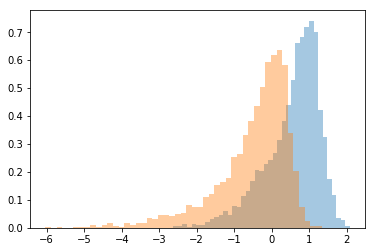

steps: 0 	 loss: 7.54874744773
new best: 7.503628511478765
state: [0.3156154968841063, 0.3167523451530927, 0.3178248364372009, 0.31611726341935104, 0.3157649908956843, 0.3162283705903946, 0.3165525099036687, 0.31580985183771487, 0.3166647056756678, 0.3172534365520153, 0.3162841926987797, 0.31548157673670724]


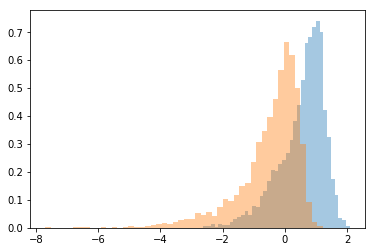

new best: 7.4093794898395124
state: [0.31479214077267376, 0.3174791285141, 0.31704346378172893, 0.3162556179242647, 0.31661835572284125, 0.31528708086568674, 0.31571380641356445, 0.3150175048308542, 0.3165515857252975, 0.31697226141976076, 0.31644666430922386, 0.3158380564072983]


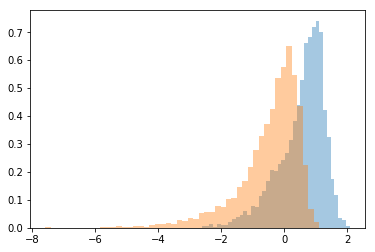

steps: 10 	 loss: 7.5587267467
steps: 20 	 loss: 7.48779094311
steps: 30 	 loss: 7.52832222808
new best: 7.40169826498939
state: [0.3170544396990561, 0.3134013365165263, 0.318447330816231, 0.3130455769091167, 0.31163056107410986, 0.3163586729250905, 0.32061429670843583, 0.31567821659329226, 0.3174453281503293, 0.3153398503453602, 0.3116461482582211, 0.3125969864492631]


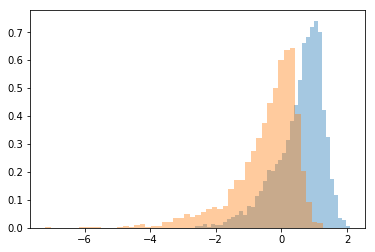

steps: 40 	 loss: 7.55446860023
steps: 50 	 loss: 7.49548756409
new best: 7.341637262668858
state: [0.31685422590346496, 0.3154152988384758, 0.3191037968642355, 0.31177373056570395, 0.3128111387925871, 0.3220292762578464, 0.3222602103283732, 0.31538694611710943, 0.31895156071590575, 0.3115309684634762, 0.3059763888593743, 0.3144440717523529]


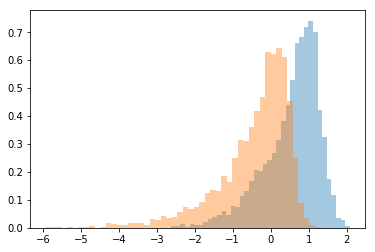

steps: 60 	 loss: 7.46563197708
new best: 7.288244312387536
state: [0.31415593566753075, 0.3149323234267736, 0.32016008673476304, 0.3147097610129757, 0.3138434307272054, 0.3261734316651155, 0.3207755091263195, 0.3160246301002655, 0.3202122128752411, 0.31562897301601983, 0.3035801730827084, 0.31443113626329455]


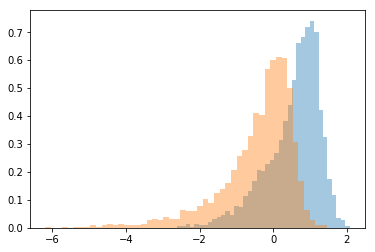

steps: 70 	 loss: 7.28824431239
new best: 7.246570309752935
state: [0.31770592897402183, 0.3145345930840606, 0.3207910344988372, 0.319463886167311, 0.3155088223291765, 0.3298998470409061, 0.32012441223466964, 0.3138270815142131, 0.3196942147928707, 0.31590795735346816, 0.30112331332783215, 0.31437842168545377]


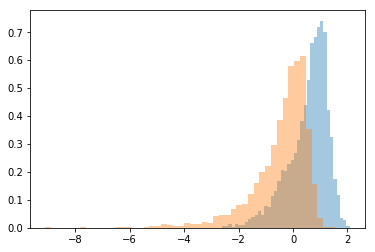

steps: 80 	 loss: 7.24657030975
steps: 90 	 loss: 7.41862858042
steps: 100 	 loss: 7.45552299181
new best: 7.186460122932276
state: [0.3165864600624728, 0.31828651120610835, 0.3237603474335892, 0.3196171860983507, 0.31597680791035904, 0.3334403147586257, 0.3195978885935181, 0.32160480891189475, 0.3193198060738189, 0.31522151466650467, 0.28966570611925907, 0.3138864188384572]


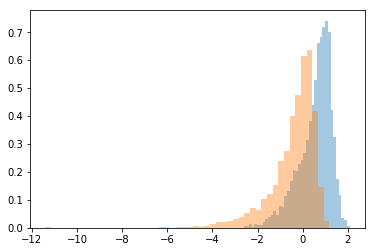

steps: 110 	 loss: 7.28196701793
steps: 120 	 loss: 7.36774414483
new best: 7.166476709925936
state: [0.31645148095746006, 0.32143471297627296, 0.3261764764207984, 0.32613988401879856, 0.31600681794441127, 0.33889186654026604, 0.3210564972333174, 0.3269653154541665, 0.3141827097763456, 0.3129001854138999, 0.27924571033042833, 0.3111425705234597]


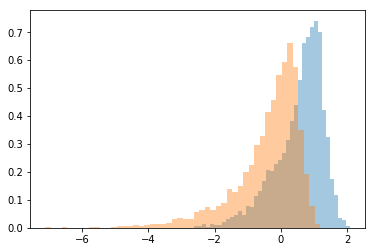

steps: 130 	 loss: 7.16647670993
new best: 7.155067292596344
state: [0.3164317376361328, 0.3213462054641669, 0.3267301774440214, 0.3268543163685274, 0.31469846441172145, 0.3380033276231328, 0.32159001921533675, 0.3278488074101463, 0.3139121235188569, 0.31315289929210144, 0.27937480641835705, 0.3109166647085633]


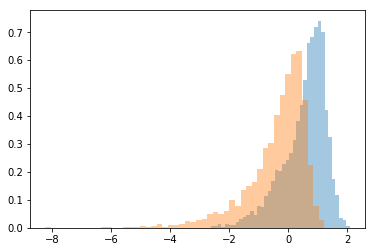

steps: 140 	 loss: 7.18563684251
new best: 7.0642544894030275
state: [0.3145212577731606, 0.3230788227591052, 0.32518558734604186, 0.3221118965132428, 0.3147592746567685, 0.34106882491398366, 0.32029076952334545, 0.32790493383261954, 0.3142498234342522, 0.31452295665667435, 0.27467689317710653, 0.31381253868237374]


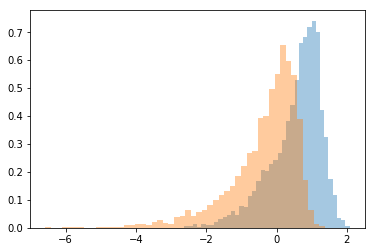

steps: 150 	 loss: 7.22274634086
steps: 160 	 loss: 7.32508588868
steps: 170 	 loss: 7.19448963206
new best: 7.0390729931920095
state: [0.31216839934008556, 0.3192197534441877, 0.31905997964185634, 0.32542731895188715, 0.3167713384367263, 0.34342549837116965, 0.32277252989979444, 0.3294534853910987, 0.31491683469589055, 0.31748138692938876, 0.26716577145435394, 0.3092942328637792]


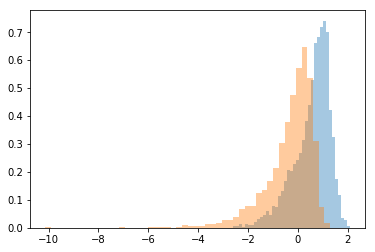

new best: 7.033822928542106
state: [0.3122374565656187, 0.3189876565647519, 0.3180004324037917, 0.32713469520623556, 0.31574385799134924, 0.34261645440411437, 0.3212905878233261, 0.329920902197319, 0.31519371335502677, 0.318435914744939, 0.2669389832638699, 0.3097423247723898]


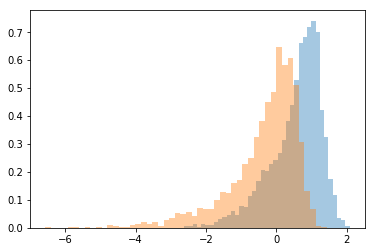

new best: 7.033153028065394
state: [0.31188712351942516, 0.3201502417012001, 0.31809469042243205, 0.3271066180010784, 0.31564987764536306, 0.34179197429423647, 0.3219785416021864, 0.32902051727998377, 0.31649284380640264, 0.31873907482079167, 0.26618216367662706, 0.31083641875503654]


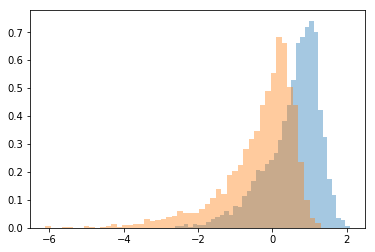

new best: 6.979226850129204
state: [0.3111226156170325, 0.3201217687660558, 0.3192831832448788, 0.3264606152600507, 0.3158514891442542, 0.3418026622824751, 0.3214500893615869, 0.3299477643270972, 0.3173888595470486, 0.3183174655886902, 0.26379459147976847, 0.30981373438629245]


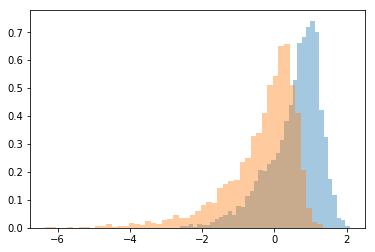

new best: 6.953864666961878
state: [0.3103551808964541, 0.32051364804255084, 0.3197067491295018, 0.3264208377332431, 0.31570381442683765, 0.34187915284837683, 0.3217693768698981, 0.329779994602373, 0.31829922936289384, 0.31728852428505466, 0.2638986384878367, 0.31041810801171993]


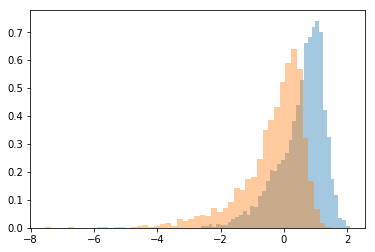

steps: 180 	 loss: 7.14480760558
steps: 190 	 loss: 7.08206853878
new best: 6.895350443946785
state: [0.30886136852072427, 0.31963833200019987, 0.31481093341812694, 0.3240704288985388, 0.31631064839771655, 0.3410174508664137, 0.32781956092689907, 0.3250103400489784, 0.31945841230102784, 0.32159978742684503, 0.25294233242740904, 0.3126372082509977]


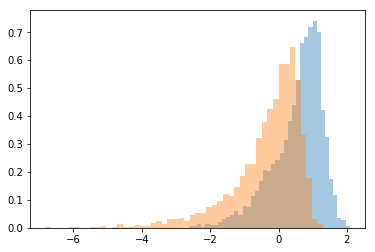

new best: 6.832310989611377
state: [0.3077006514665356, 0.32232389189136434, 0.3115601098112157, 0.3250463922497408, 0.3167576720875433, 0.34181136537914225, 0.3271459889039146, 0.32388817215915733, 0.3176895965665117, 0.3204813530243292, 0.2498353810294129, 0.3132509111931101]


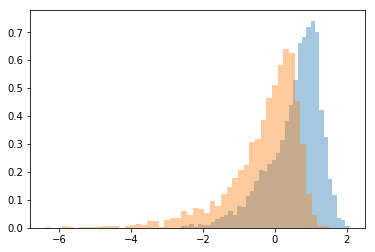

steps: 200 	 loss: 6.87052426251
new best: 6.795108866369048
state: [0.3074645078538454, 0.32221053553111256, 0.31301273486291303, 0.32597221732522896, 0.3147340911538164, 0.34176280340201853, 0.32863606324859207, 0.3243440879920517, 0.31714566971805414, 0.32132858210537424, 0.24793262699675242, 0.3116798870161194]


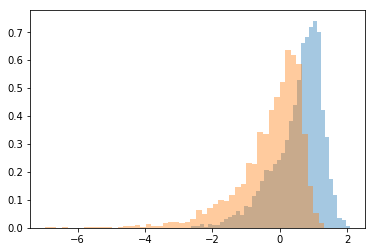

steps: 210 	 loss: 6.989336316
new best: 6.738700689687371
state: [0.3080315824563695, 0.3241305578956623, 0.3175921275175847, 0.3264261838934237, 0.31515482624725516, 0.3452047607831435, 0.32378133047951146, 0.32691116103604284, 0.3179074673586858, 0.317463312181042, 0.23849069843080084, 0.31268712149087297]


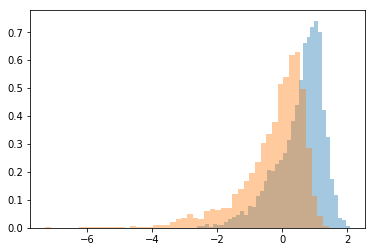

new best: 6.682035687347968
state: [0.30748241529883663, 0.3255515588803059, 0.3185729620121182, 0.3258868675563358, 0.3166075856396328, 0.34555886357127663, 0.3252350358678259, 0.32566476482658185, 0.3167577872652455, 0.31729626452217385, 0.2385476492174326, 0.3120673415106287]


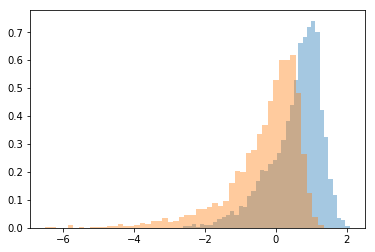

new best: 6.482931259015409
state: [0.3067175977376046, 0.32570843381090175, 0.3196147319799472, 0.3238371992266379, 0.31490314066026853, 0.34626155570662187, 0.3233009371376122, 0.3269952901791885, 0.3162696254687865, 0.31567324003916325, 0.23622196615361463, 0.31198207535641104]


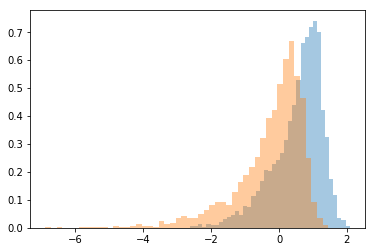

steps: 220 	 loss: 6.72166772638
steps: 230 	 loss: 6.81971345258
new best: 6.416238370302603
state: [0.3059708174777046, 0.32190396877960314, 0.32514782167124345, 0.3189453382803749, 0.31521814285847494, 0.3508304406125666, 0.3240650445310042, 0.3218701607570564, 0.3108849023524368, 0.3160912986988324, 0.22542953148254644, 0.3136785559882788]


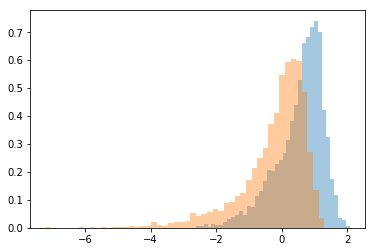

steps: 240 	 loss: 6.53744363179
new best: 6.2874854113544805
state: [0.304577155045396, 0.32348097636481016, 0.32871331310385843, 0.32220807535289764, 0.31690098677999484, 0.35064353281810706, 0.3247285934243143, 0.32328845212369656, 0.30992407828444163, 0.3142094472983013, 0.22037762989263565, 0.31086660944860395]


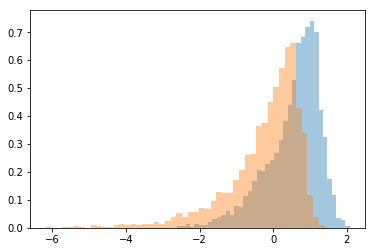

new best: 6.246179700056046
state: [0.3062393188009846, 0.32504101606305646, 0.3310626951781599, 0.3227540864801847, 0.316345299726169, 0.3525491339924997, 0.324657483960439, 0.3240522541391389, 0.31147455621024855, 0.31469622492063715, 0.21494417986175224, 0.30863702563376594]


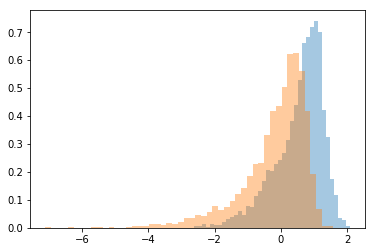

new best: 6.114041672496089
state: [0.3064885995185807, 0.3250946502460617, 0.3314777993767388, 0.323041098734778, 0.3160131091203667, 0.35189244905372546, 0.3243671798317457, 0.3238602100731272, 0.31089042879323814, 0.31418631383845524, 0.21516497345074836, 0.3087315631885167]


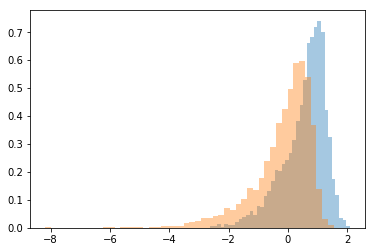

steps: 250 	 loss: 6.51853927572
steps: 260 	 loss: 6.19648543281
steps: 270 	 loss: 6.29318968266
new best: 6.111866840377339
state: [0.3037181036844233, 0.32635598022814255, 0.3315108167892013, 0.32560642121966094, 0.3208761647027517, 0.35705527903572376, 0.3187214122781465, 0.323598313940479, 0.30640269814092336, 0.31374457467123085, 0.20306811946560188, 0.31049845163522916]


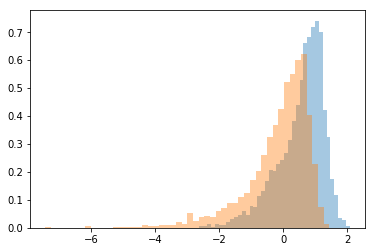

new best: 6.102579086406794
state: [0.30585192248897247, 0.32626808925874, 0.3347635893724463, 0.3225261718475935, 0.3207587070418379, 0.3581937100224245, 0.31953982458262653, 0.32083367131954393, 0.3079409390675186, 0.31240157939406915, 0.2024829367745965, 0.31361904658249706]


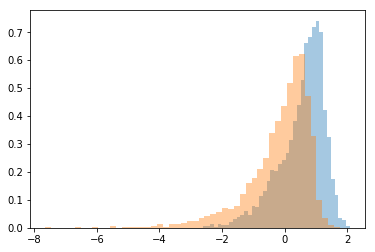

new best: 6.032015653548171
state: [0.30556160376505703, 0.3273974854965128, 0.3373009817842029, 0.32113724983184655, 0.32053714598941674, 0.35718751777415, 0.31963178133743975, 0.32302878842879335, 0.3096349813061689, 0.310033985382306, 0.19943692977444147, 0.31586546126387344]


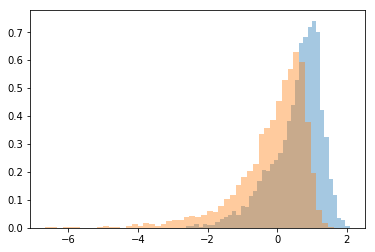

steps: 280 	 loss: 6.22721980663
new best: 5.94645637397458
state: [0.303916782809534, 0.32955520563442814, 0.34008577609539126, 0.32132158557763657, 0.3209164078981387, 0.3636565062120313, 0.3182459355276608, 0.31883880139337933, 0.31202469365077795, 0.3128171194933547, 0.19531153334096707, 0.31478428854359647]


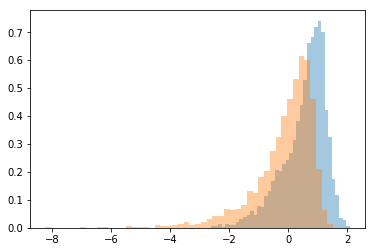

steps: 290 	 loss: 6.18847077043
new best: 5.919993752008806
state: [0.30029740098921964, 0.33381385842227224, 0.33790326794300257, 0.3194974077733026, 0.3257927158719806, 0.3650951671498392, 0.31924566438970636, 0.31833654214815077, 0.3106019406418768, 0.31066660704224147, 0.19437391943565915, 0.3169858922860962]


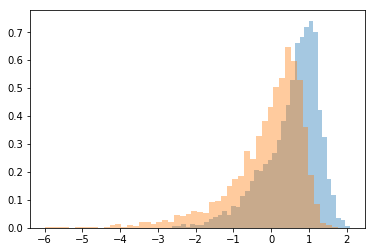

steps: 300 	 loss: 6.05848218715
new best: 5.648273957379855
state: [0.29942675865852036, 0.3312596137300413, 0.3398373317803731, 0.31715712967218623, 0.3259306488913838, 0.3662256440655108, 0.3204744746395961, 0.32133426276860144, 0.3146437370832214, 0.3107005608663563, 0.1890139726391474, 0.3168764389243685]


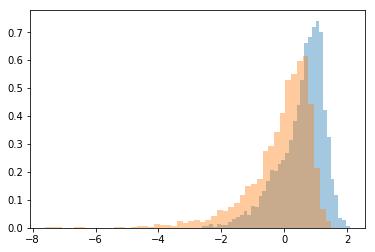

steps: 310 	 loss: 5.87236111369
new best: 5.588520072785976
state: [0.29624193758266437, 0.33061437058122073, 0.3382115605181222, 0.31420364234940423, 0.32573895921001944, 0.37094242859262416, 0.32233503138915354, 0.3252641973785845, 0.3208907769896525, 0.3136945960397438, 0.1792644856821973, 0.3145592523139234]


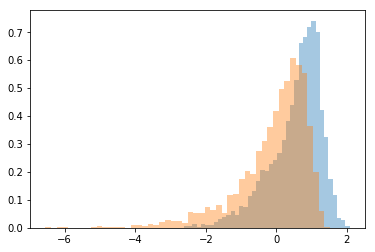

new best: 5.4340716217166465
state: [0.2960749007593145, 0.3310243055560345, 0.33857085343291343, 0.31446685058595614, 0.32759197918302563, 0.3712475190547134, 0.32243749004519584, 0.3239365722663965, 0.3204105359517665, 0.31336381187374457, 0.17869749280423447, 0.3159054922824895]


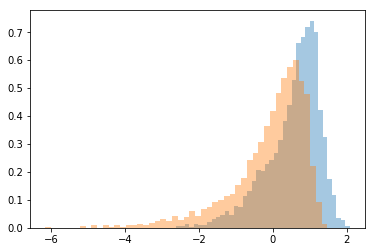

new best: 5.424726470926771
state: [0.2936180813900312, 0.3287566706432798, 0.33975704736600176, 0.31459276006189946, 0.3276770153466887, 0.37281348825327576, 0.32311054752912133, 0.32245568924906215, 0.32158722479248997, 0.3124338921814418, 0.17744296214993258, 0.31689903496622596]


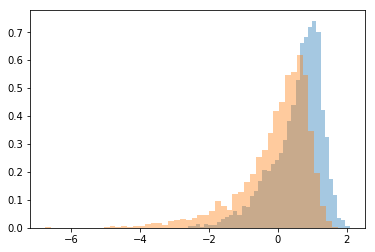

steps: 320 	 loss: 5.67030566661
new best: 5.397840350344251
state: [0.2953625940844777, 0.3341007948413331, 0.34053675418409984, 0.3145761481859513, 0.32367758395967433, 0.371916548446975, 0.3211617221139571, 0.32190478850107285, 0.3205106653331679, 0.312478695048526, 0.17392636661811853, 0.3179710439726226]


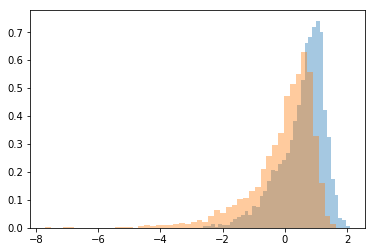

new best: 5.328461746595536
state: [0.29564209458210094, 0.3346257560625326, 0.33921084014054576, 0.31528108911856273, 0.32580072101353075, 0.372047259880397, 0.3217496233534548, 0.3205905899779301, 0.32458056554875064, 0.3125821671551507, 0.17031783400151354, 0.31946506678933506]


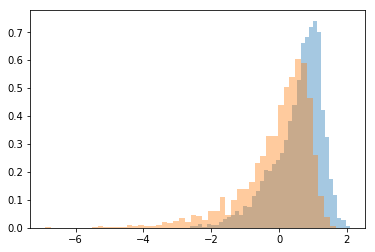

new best: 5.115593868558272
state: [0.29602090224104693, 0.3340660461238179, 0.3447128611758049, 0.3167935842114481, 0.32589142808998517, 0.3734262967108834, 0.3202908729803019, 0.31986557223293327, 0.32495600521772994, 0.31153025297163006, 0.1608221211047481, 0.31702738967848815]


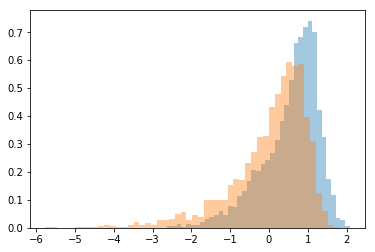

steps: 330 	 loss: 5.27138400725
new best: 4.89548126167905
state: [0.29473683549723567, 0.33414257075072734, 0.3442294956411213, 0.3168222081833151, 0.3255804290350194, 0.3772470498202896, 0.32182172779689594, 0.31929709561147773, 0.32905684641781185, 0.3132208158551386, 0.15736437876507178, 0.3195969041704615]


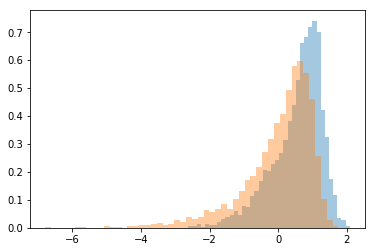

new best: 4.490912936156474
state: [0.2937726003790363, 0.3331226642186689, 0.34473251079363637, 0.3164527938097028, 0.32675275318670655, 0.3775452537083695, 0.3236299230738216, 0.3192379001160749, 0.32863508676906905, 0.3145862985144703, 0.1568707602818992, 0.31873490364730955]


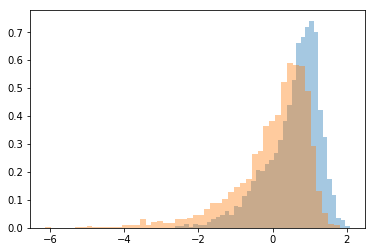

new best: 4.316173558201348
state: [0.29542291697607403, 0.3270243268441318, 0.3440911545639614, 0.3161582101847388, 0.3288289494216906, 0.3738589135434155, 0.32957344101748326, 0.32090814093327574, 0.32859444652566494, 0.31359913588899674, 0.15168775008768573, 0.3180935883456321]


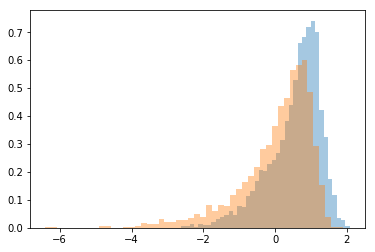

steps: 340 	 loss: 4.3161735582
new best: 4.21313094209778
state: [0.2960980247879586, 0.32385669023598235, 0.3455048519334996, 0.31563043933320234, 0.3262723304125699, 0.3788014110733705, 0.32411467158418505, 0.31876619808099216, 0.3300008779035856, 0.31160458526841267, 0.1454249888383368, 0.31291077509405235]


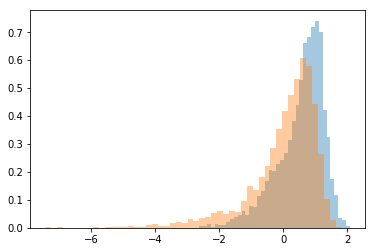

steps: 350 	 loss: 4.45468682642
new best: 4.063959765832204
state: [0.2979331252398333, 0.32370932109172634, 0.34474717293789475, 0.3169216775281062, 0.32507436753454, 0.37779381058788414, 0.32208337233901235, 0.31714893742745326, 0.3269575252397929, 0.31019779692750854, 0.14314493560811947, 0.3108239534972612]


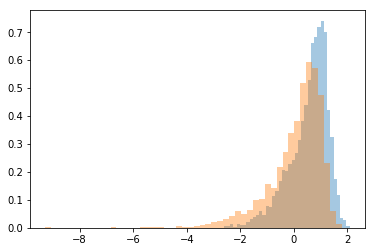

new best: 3.9014461248419336
state: [0.29980827633037693, 0.3265329143036978, 0.3438805726781465, 0.31834200299429566, 0.3268104538208818, 0.3776325805387801, 0.3208569373256619, 0.317771381981128, 0.3263568930517621, 0.3104769548082865, 0.14205962208012266, 0.3091193847142085]


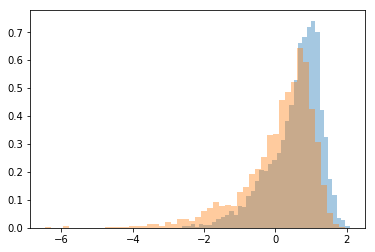

new best: 3.4980775716302563
state: [0.3001002163209492, 0.3253298447657908, 0.3425337535838118, 0.318720002054167, 0.32661844739721607, 0.37765176647011617, 0.319167753866252, 0.31839127965996716, 0.3252654496178094, 0.3097620586282975, 0.14004847535218706, 0.3094113907834308]


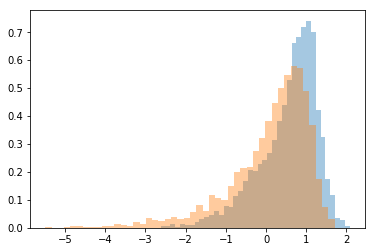

new best: 3.4902377588063027
state: [0.30164200976052, 0.326609574398172, 0.3393846032902946, 0.32142439809045475, 0.32472920299784447, 0.3782216562725224, 0.32009555169548404, 0.3191763140163438, 0.3254247221642321, 0.314910613327206, 0.13146194753768153, 0.30754336936624893]


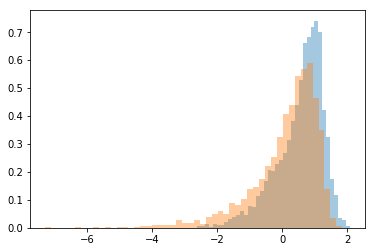

steps: 360 	 loss: 3.49023775881
new best: 3.076902634881183
state: [0.2996004771019844, 0.3255751498791791, 0.3395574090579874, 0.32134097756391183, 0.32416742364674894, 0.3769630160596489, 0.32040537166650745, 0.31882034580259233, 0.3279242465676216, 0.3154571165434568, 0.13137486897492134, 0.3078696024342316]


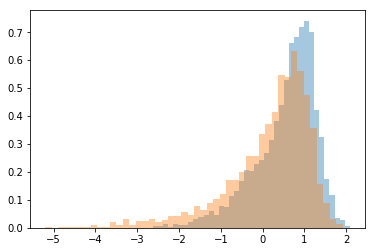

new best: 2.948099585527941
state: [0.30533399292192287, 0.32811406280136884, 0.3410322507521182, 0.3233922549690119, 0.32608362863251866, 0.37512407562872285, 0.32624165073340755, 0.32129213106468524, 0.3320155876207822, 0.31728291422746313, 0.1264257341642287, 0.31128127187720095]


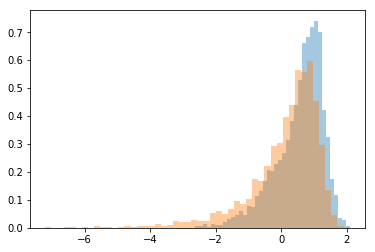

steps: 370 	 loss: 3.64864849269
new best: 2.6402348327175953
state: [0.3090658723943848, 0.33243688149620987, 0.343611394123968, 0.32530521334557283, 0.3270071693027165, 0.3731211553222133, 0.3299042589620754, 0.32160733920507506, 0.3327169723612744, 0.3116971194892866, 0.12248383525920467, 0.3115678812168725]


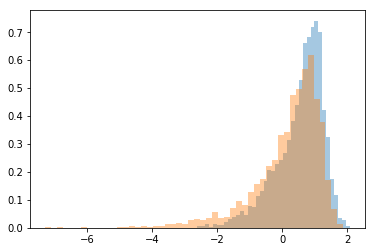

new best: 2.5081255737201955
state: [0.30868983055285804, 0.3332201956160698, 0.3422877588836486, 0.326608119939994, 0.3266882370660878, 0.37392485524955493, 0.3293414100017184, 0.3214890382139067, 0.3319196250875246, 0.31359870203012913, 0.12260254796695057, 0.3100555397742788]


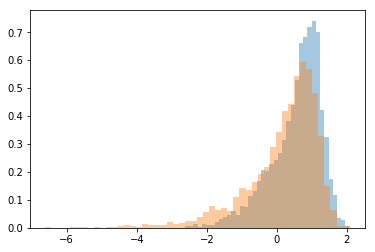

steps: 380 	 loss: 2.84020261191
new best: 2.0501452696339832
state: [0.30973430930292206, 0.3300120287160455, 0.34437750229272546, 0.32462863643192136, 0.3251498948768309, 0.37226498777262385, 0.32667024455593935, 0.3201507886806222, 0.32953466267892595, 0.31659205589001743, 0.1174355042488934, 0.31364241409193655]


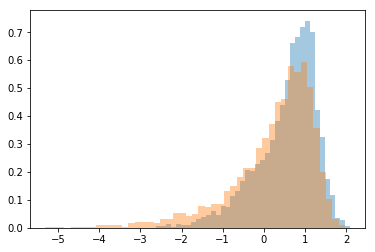

new best: 1.7682134409793542
state: [0.3127259138951156, 0.3329502285556485, 0.3475787510455234, 0.3218547159426043, 0.324871084462831, 0.37016775100948135, 0.32713896048709523, 0.3190615391135175, 0.33050985934104105, 0.3181828891956921, 0.11517809832778081, 0.3134231485440715]


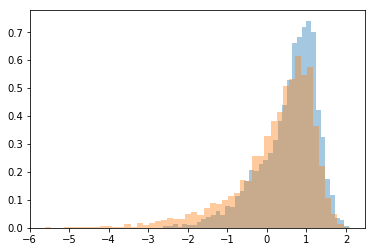

steps: 390 	 loss: 2.17845396615
new best: 1.4253077703195418
state: [0.3115349705337415, 0.3324365643944987, 0.34821962913519416, 0.32009905363784685, 0.3227327913999249, 0.3729503419311412, 0.3299254149193049, 0.3203204544511035, 0.3321624923382161, 0.31930460556030393, 0.11014832140367369, 0.3126960820765401]


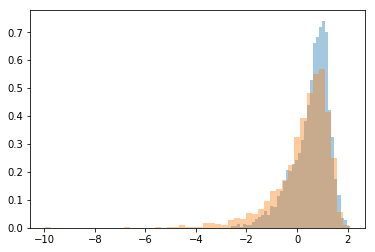

new best: 1.3182799330138968
state: [0.3122938166991901, 0.33198689756897987, 0.3493124998408723, 0.32267765267492277, 0.321583927899467, 0.3715261353165423, 0.3248705267808698, 0.31946587706525165, 0.331110634942014, 0.3189591193395016, 0.10542104835225061, 0.3148062199264918]


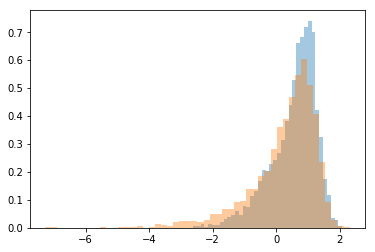

new best: 1.3056139730689125
state: [0.31620938041863356, 0.33196816012330277, 0.3503471519653188, 0.32153268279417097, 0.32298381254488706, 0.3728151234863397, 0.3243014767754719, 0.31934926502965316, 0.3286970147886441, 0.3196960586360321, 0.10088226515383317, 0.3161512377552699]


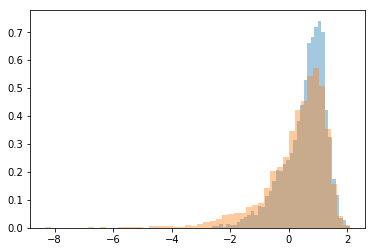

steps: 400 	 loss: 1.61392427485
new best: 1.0985919222778704
state: [0.31611063803264533, 0.33276814510937847, 0.34917082591793186, 0.3210503942160963, 0.32097638297071396, 0.3718851362869202, 0.32608546737880156, 0.3184029195222133, 0.3292466691395947, 0.32143090863936236, 0.09947168542353736, 0.3143554305802745]


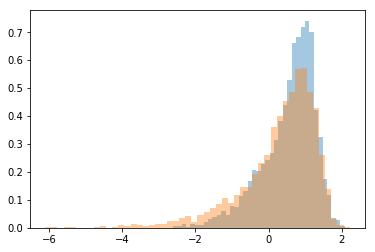

new best: 1.0648075497351224
state: [0.31676328979527313, 0.33240232621712545, 0.34939698942420827, 0.32157452773528983, 0.3219816783993291, 0.3718770050992477, 0.3259956471438662, 0.31785012315404376, 0.32855534894150973, 0.3208151277253264, 0.09967202194476422, 0.3158865154313078]


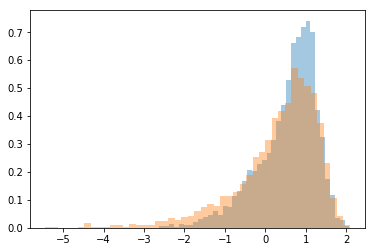

steps: 410 	 loss: 1.22566137604
new best: 1.0368564670643843
state: [0.31782850815502356, 0.3321493676884202, 0.34951405321395407, 0.3189196258903642, 0.31849123818329567, 0.3735412327861347, 0.324727251359775, 0.3165337579722494, 0.32563425500935134, 0.32043423177935976, 0.0969811230587139, 0.3159315135819754]


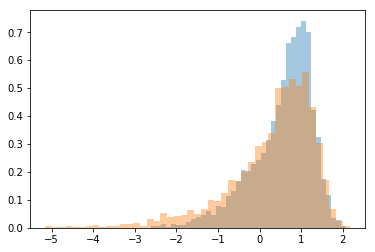

new best: 1.0351607170146455
state: [0.3175303548723105, 0.3314651494881084, 0.35093548478156117, 0.3188226278065339, 0.3179375635353236, 0.37335921961223195, 0.3251447432172343, 0.3168956760715985, 0.32416095339200873, 0.321886415244625, 0.09708037978946962, 0.31517589102907295]


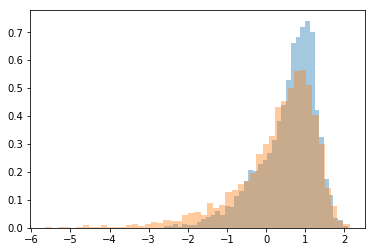

steps: 420 	 loss: 1.23142833628
steps: 430 	 loss: 1.66739776504
steps: 440 	 loss: 1.12059214339
steps: 450 	 loss: 1.34800114487
new best: 1.0080667297610042
state: [0.31402382820096597, 0.33899058607799093, 0.34323569917286273, 0.31353309502872173, 0.31646282702710254, 0.3668903398070796, 0.32405646731888615, 0.31271505521586235, 0.32388263245475263, 0.32210823032066194, 0.09557253559572647, 0.31762975261019105]


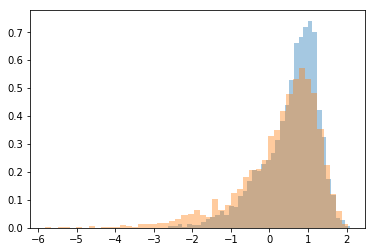

steps: 460 	 loss: 1.48937003786
steps: 470 	 loss: 1.56114534969
steps: 480 	 loss: 1.39005793878
steps: 490 	 loss: 1.23784142504
steps: 500 	 loss: 1.46160824654
steps: 510 	 loss: 1.45298260593
new best: 0.856394462281889
state: [0.3075572509967724, 0.3437033573713772, 0.3379738500154169, 0.3109896573378327, 0.31450281908094607, 0.37010788175103954, 0.32825564722054357, 0.3173262251233105, 0.33014488763887334, 0.3230812099313731, 0.09618149396040937, 0.3131053688805842]


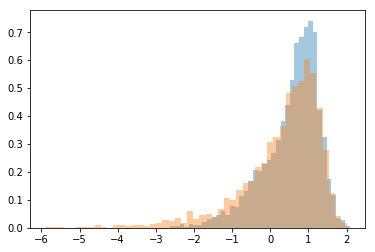

steps: 520 	 loss: 1.57582405244
steps: 530 	 loss: 1.40768999623
steps: 540 	 loss: 1.46104751182
steps: 550 	 loss: 1.56199513024
steps: 560 	 loss: 1.06498911211
steps: 570 	 loss: 1.24037908899
steps: 580 	 loss: 1.0060872713
new best: 0.834953578576203
state: [0.31150916927736866, 0.3386953044140634, 0.34247500244224743, 0.3071570077319391, 0.3178672078866767, 0.37051799237509564, 0.3277549289114449, 0.3181752916837977, 0.33362900943709695, 0.33332375045916646, 0.0978092436319974, 0.3090641786757311]


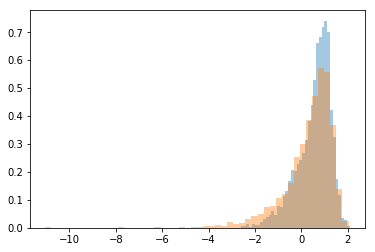

steps: 590 	 loss: 1.36231428085
steps: 600 	 loss: 1.40481923387
steps: 610 	 loss: 1.03663853185
steps: 620 	 loss: 1.12048395124
steps: 630 	 loss: 1.3593850479
steps: 640 	 loss: 1.17795237331
steps: 650 	 loss: 1.69986549644
steps: 660 	 loss: 1.137550908
steps: 670 	 loss: 1.4572230533
steps: 680 	 loss: 1.28882864515
steps: 690 	 loss: 2.01489943956
steps: 700 	 loss: 1.2371096355
steps: 710 	 loss: 1.0744826951
steps: 720 	 loss: 1.2179871717
steps: 730 	 loss: 1.37275263511
steps: 740 	 loss: 1.25145957075
steps: 750 	 loss: 1.13321442204
steps: 760 	 loss: 1.07464893415
steps: 770 	 loss: 1.07938582367
steps: 780 	 loss: 1.47381501928
steps: 790 	 loss: 1.24609300152
steps: 800 	 loss: 1.23039318215
steps: 810 	 loss: 1.27858322031
steps: 820 	 loss: 1.04417964725
steps: 830 	 loss: 1.1545969832
steps: 840 	 loss: 1.05196493579
steps: 850 	 loss: 1.41690207088
steps: 860 	 loss: 1.23532624968
steps: 870 	 loss: 1.44733013145
steps: 880 	 loss: 1.24568696743
steps: 890 	 loss:

KeyboardInterrupt: 

In [3]:
gradient_descent(initial_vars(10), gradwidth=.01, lr=.0001)    

new best: 7.5337141541121015
state: [0.31622776624305377, 0.3162277642256474, 0.3162277658307136, 0.3162277666455223, 0.31622776562740806, 0.316227767153235, 0.3162277668631622, 0.3162277650086241, 0.3162277665988268, 0.3162277675425792, 0.31622776819364606, 0.31622776543338155]


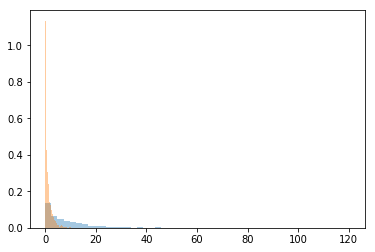

steps: 0 	 loss: 7.53371415411
new best: 7.4847762172939
state: [0.3171987825331432, 0.3157690189779079, 0.31590374630137835, 0.31752578145513083, 0.31716428604391395, 0.3166522013473964, 0.3180931001324047, 0.31749763180981005, 0.31752125808305276, 0.3174131576363081, 0.31510774111356843, 0.3161724720534664]


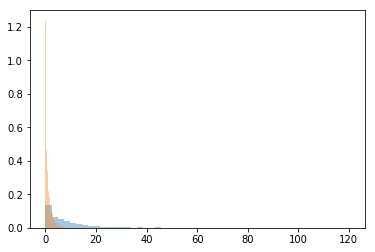

new best: 7.475295594215034
state: [0.3168168615875831, 0.3155849538649789, 0.31553198424817114, 0.3189063787753289, 0.3174816470574976, 0.31647566110120934, 0.31774570938065677, 0.31674783067692774, 0.317697653215649, 0.31740566600628384, 0.3154407242838892, 0.31606252931006606]


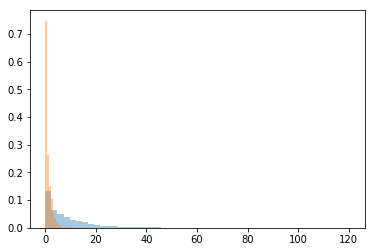

new best: 7.442584693735303
state: [0.3185452137215616, 0.3180018328992077, 0.31423870134739507, 0.3200474304055, 0.31826203328041636, 0.3163411565754205, 0.31677933307460227, 0.3176341980659834, 0.31760891310572403, 0.3195050236316213, 0.31408734338914635, 0.3152081999348836]


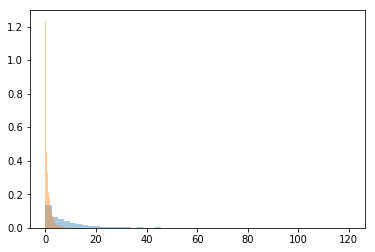

new best: 7.392590905483042
state: [0.3183474919354794, 0.3182275095773359, 0.31526955791898675, 0.3209516238342419, 0.3167669664688169, 0.31699350284089445, 0.3153536990704817, 0.3186154385244531, 0.3180889478757089, 0.3196518458662265, 0.3141767372292339, 0.31508061662153164]


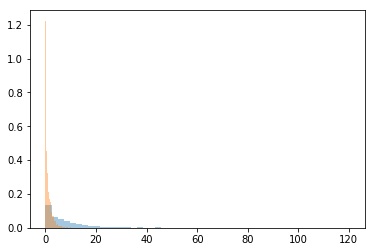

steps: 10 	 loss: 7.39259090548
steps: 20 	 loss: 7.41235407851
new best: 7.391572612047674
state: [0.31880040456136316, 0.31663622688554516, 0.31735438062998467, 0.32073429847878915, 0.31533318482624173, 0.3177923308513957, 0.3161953545952919, 0.32225431111804237, 0.3199203403701008, 0.31965693736718775, 0.3117296200968839, 0.314434756578184]


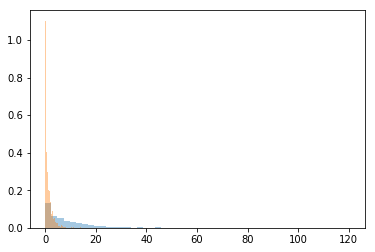

steps: 30 	 loss: 7.48677683884
new best: 7.360378939361899
state: [0.31659757236927116, 0.3189317679069239, 0.3228156548518776, 0.3231633763736186, 0.31438460135964985, 0.3177910479517877, 0.31659520419766646, 0.3231946435902169, 0.32079877659202927, 0.32268018377451163, 0.30859963600126367, 0.31274508108911636]


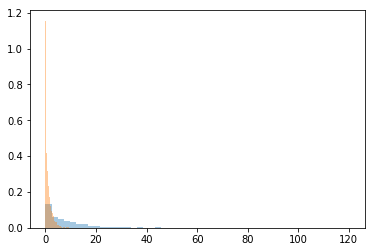

steps: 40 	 loss: 7.48516319781
new best: 7.35287136985752
state: [0.31884244761326064, 0.3176753209318259, 0.3224760427971643, 0.3274194586420185, 0.31551413586646393, 0.3198958036451339, 0.31399973394012654, 0.3225131361119857, 0.320954087107949, 0.3268062246398454, 0.3045494712611704, 0.3137382698329765]


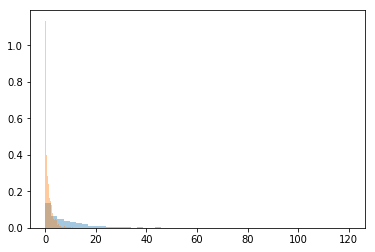

new best: 7.2839152331473285
state: [0.3178188147343959, 0.31740107788610167, 0.32141867732598145, 0.3270592431353631, 0.31662098581031456, 0.3202546434416418, 0.3138101343915398, 0.3249833528078535, 0.3227664104361612, 0.32770099735305414, 0.3012639747876143, 0.3140968534785519]


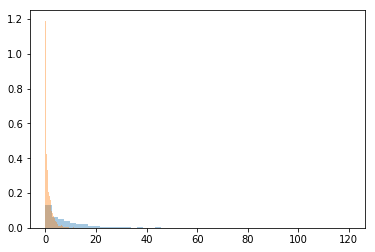

steps: 50 	 loss: 7.35820713927
steps: 60 	 loss: 7.29898144078
new best: 7.216937436964978
state: [0.3189749245188854, 0.3177558815036685, 0.31950256846712555, 0.326823667857288, 0.31724524030147117, 0.3187769379354728, 0.31538385014729275, 0.32692933520778383, 0.3250248630707121, 0.3306986277102934, 0.2956818475683201, 0.31545570228523306]


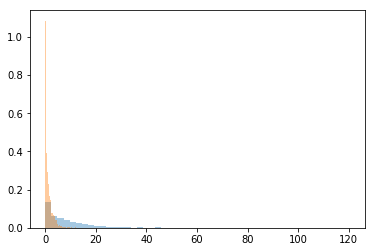

steps: 70 	 loss: 7.29655850994
steps: 80 	 loss: 7.4413151488
steps: 90 	 loss: 7.30846563354
new best: 7.211622588203051
state: [0.32452469006794515, 0.31502010707894046, 0.3177974184770471, 0.33196461127180055, 0.32230825272414815, 0.31802618747418754, 0.31621554259620405, 0.3319855665761407, 0.32388767052906714, 0.3330987529518447, 0.28647746135684843, 0.31474272651346163]


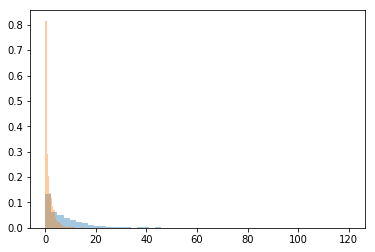

new best: 7.188465620469648
state: [0.32394685582965466, 0.31494849282431375, 0.31814072051134873, 0.3323884310212481, 0.3224195267374187, 0.31843985198182495, 0.31552838552346335, 0.33119269680162905, 0.3234609726638864, 0.33321226138450916, 0.28545082272558836, 0.31524415743962697]


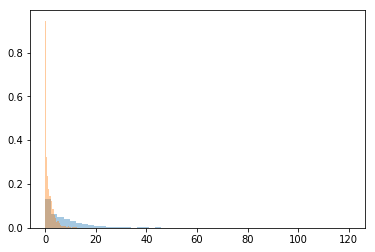

new best: 7.162743382324215
state: [0.32549110710384555, 0.3137221489583698, 0.31724563463273264, 0.33174505114654596, 0.3227586120623808, 0.3185659100923282, 0.317274022228422, 0.33098264612057626, 0.3228198682114649, 0.33399855566253206, 0.28554295627368753, 0.3153761457227629]


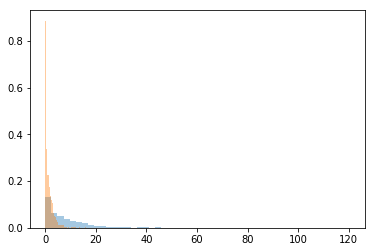

steps: 100 	 loss: 7.1849696505
steps: 110 	 loss: 7.33098465491
new best: 7.089307172788608
state: [0.326055035282597, 0.31389738756471663, 0.31325264645319184, 0.33117578519293256, 0.3247957501074533, 0.318749407372448, 0.31712956649603796, 0.3311589799695353, 0.32464172671301667, 0.3321074221965719, 0.2791670822006926, 0.31002577540406584]


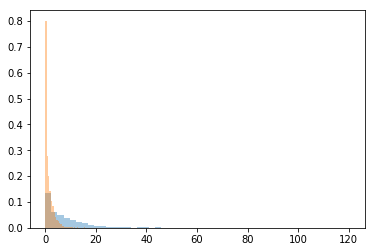

steps: 120 	 loss: 7.12185613617
new best: 7.051270079996293
state: [0.32675760270639576, 0.31666374791137647, 0.3128973825010854, 0.33030570844127477, 0.32455501157054034, 0.3208620113112031, 0.317792717703657, 0.3301191263429335, 0.32414540463460334, 0.33445354559626006, 0.27820125202177054, 0.30962651811670516]


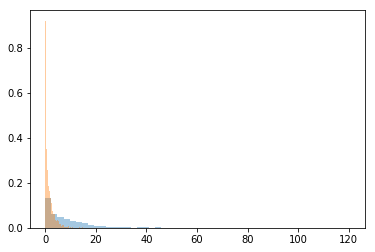

new best: 7.043142037731997
state: [0.32732105860859934, 0.31635651093332173, 0.3116645285040898, 0.3299546059130569, 0.32441662417424916, 0.32042768908519775, 0.3185541924095702, 0.33047507602639936, 0.32410281601249524, 0.334010360324992, 0.27840732166307786, 0.308722492407857]


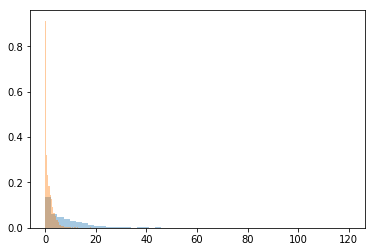

new best: 7.025342323703208
state: [0.3284371621675781, 0.31863534502191226, 0.3102447766147969, 0.3315117740011734, 0.32429022614838143, 0.32236398509974845, 0.3183516413366356, 0.33250832051825424, 0.3263411074955416, 0.3355163181882566, 0.27829393763629584, 0.30546043273966483]


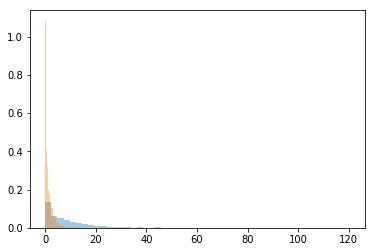

steps: 130 	 loss: 7.0253423237
new best: 7.024161256623607
state: [0.3292890931051903, 0.3183525321426141, 0.31166020813322065, 0.33110790342270985, 0.3252406617128818, 0.32242532644026245, 0.3186864376383596, 0.33277640505079215, 0.3237522991268711, 0.33569653767396507, 0.27832704350436893, 0.30648299166046933]


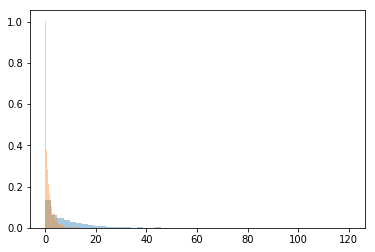

steps: 140 	 loss: 7.1650877712
steps: 150 	 loss: 7.17040760309
new best: 6.864724986727263
state: [0.33015214325012077, 0.3211979178950616, 0.30840633628886543, 0.3316341431159567, 0.32705874851215877, 0.3218041383442317, 0.3150709040088308, 0.3345531627007537, 0.32094480071395315, 0.3312669535195819, 0.26536637285886344, 0.31020758131994747]


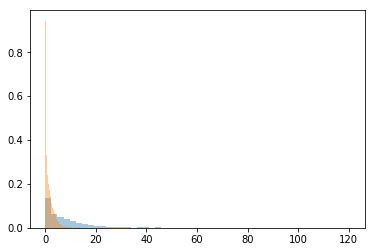

new best: 6.830098961914093
state: [0.3316551414453803, 0.3207867105024135, 0.31028118426696594, 0.3306079550261295, 0.3289560141316131, 0.3210925648778044, 0.31315651469189987, 0.33488929960231884, 0.3198826395867917, 0.33163320393388246, 0.26520454850201775, 0.30925053609910136]


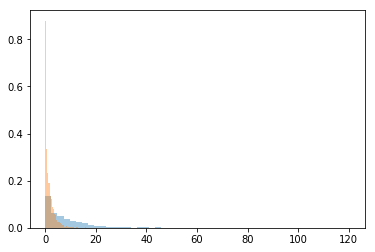

steps: 160 	 loss: 7.20527759106
steps: 170 	 loss: 7.19333244705
new best: 6.735177579193331
state: [0.32381778148067336, 0.317245498236967, 0.30724179483362757, 0.33687842207926133, 0.3260349347889748, 0.3242887378958811, 0.3149548725646964, 0.3347341374759282, 0.3215420131148624, 0.3345321469508603, 0.25282539553659256, 0.30291919185892263]


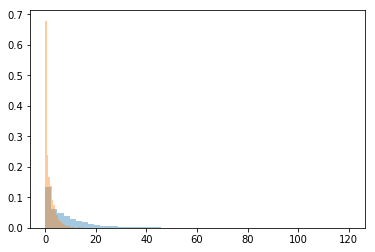

steps: 180 	 loss: 6.73517757919
steps: 190 	 loss: 6.85133032684
steps: 200 	 loss: 6.96228271671
new best: 6.601973077415135
state: [0.3312769229159317, 0.32130849989544347, 0.30813387217920885, 0.3396167955742169, 0.3266943878336801, 0.32197776253423754, 0.3089428272578186, 0.33367061333744596, 0.3213681312059299, 0.33577404628467256, 0.24718243032892379, 0.29950351383332785]


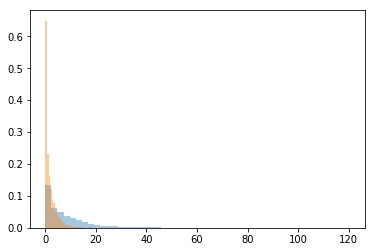

steps: 210 	 loss: 6.74978792762
steps: 220 	 loss: 6.73216002903
new best: 6.457506676741473
state: [0.3311832117024591, 0.3204120815475832, 0.30271432126016745, 0.3385378090351745, 0.3290219880417028, 0.3166637822844742, 0.30614906879407144, 0.3297114665515704, 0.32567422505159466, 0.33517456301826315, 0.23746457860474446, 0.28686124196241847]


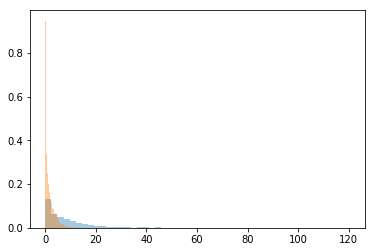

steps: 230 	 loss: 6.78074246668
steps: 240 	 loss: 6.64704914012
new best: 6.376348772970752
state: [0.3253012513658776, 0.3215902361782944, 0.30383612818728784, 0.33655999394077984, 0.3299982266956918, 0.3188177793552003, 0.3003318752483924, 0.33070851941018425, 0.32537978008551255, 0.33097463309358255, 0.23369861330287517, 0.2865201249055172]


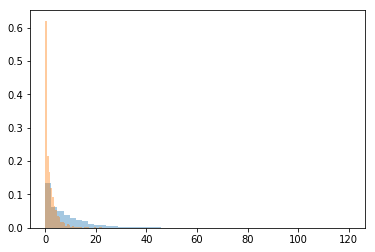

steps: 250 	 loss: 6.54721495699
steps: 260 	 loss: 6.47642237888
new best: 6.341509255702736
state: [0.33040091619667766, 0.31926073456554666, 0.3016767014981349, 0.33147370571226487, 0.33335596988911875, 0.3168795898621297, 0.30082741692079606, 0.3335345539213481, 0.32270370700963136, 0.33156921505860304, 0.2273325512696345, 0.28270945128220626]


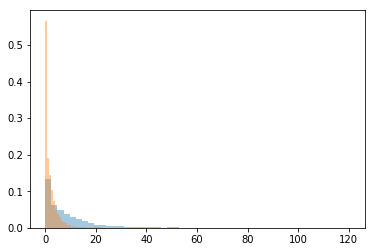

steps: 270 	 loss: 6.59859480365
new best: 6.316745933966162
state: [0.3299374572683817, 0.31557966589277897, 0.2996429105198034, 0.33282168698228887, 0.3359679209018769, 0.31055533810359665, 0.3008931342906088, 0.3346019384428433, 0.32302375628823254, 0.3303517184809734, 0.2222025672817674, 0.2866966406309833]


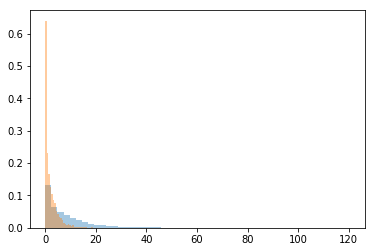

steps: 280 	 loss: 6.54785174436
new best: 6.308651636048064
state: [0.32945954046975395, 0.315618328387526, 0.3006925651152934, 0.332149591346107, 0.3358819301341857, 0.3094320386697952, 0.3014961232000264, 0.3352983560715094, 0.3241268417849751, 0.32946623929916913, 0.21997065425816073, 0.2872714232473854]


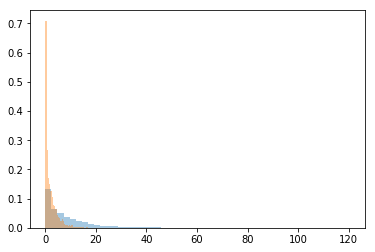

steps: 290 	 loss: 6.41694364562
new best: 6.2108959830259005
state: [0.33077873117115203, 0.31630347810725107, 0.3019740576194812, 0.33608676464114673, 0.3372327498849748, 0.30645589434811965, 0.3055521286535793, 0.33562672560086837, 0.3268163892317444, 0.3285597052124073, 0.21519487726761402, 0.28647525271090285]


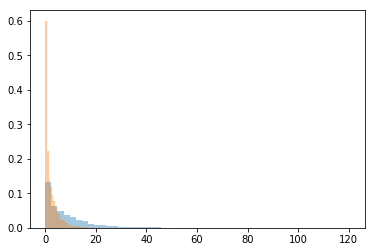

steps: 300 	 loss: 6.22634686474
new best: 6.143190879498364
state: [0.33274031778324636, 0.3162238930403943, 0.3004283542070272, 0.33808430919445637, 0.3374828788627342, 0.30785887481778373, 0.30305108263982317, 0.3340609364085796, 0.3261097245997171, 0.33060490812171095, 0.2091414654594303, 0.28452102250002737]


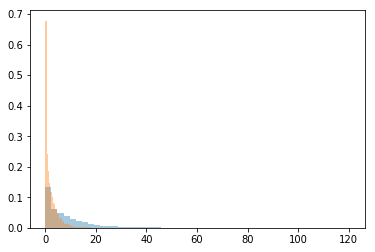

new best: 6.0609524599189415
state: [0.33190585311307164, 0.31889134237699535, 0.30356338694250823, 0.337934824642411, 0.3397874830814297, 0.3092122445525294, 0.30578195631354765, 0.335225534313732, 0.32800960158026693, 0.33206783034741755, 0.20723898903700688, 0.2856336564511954]


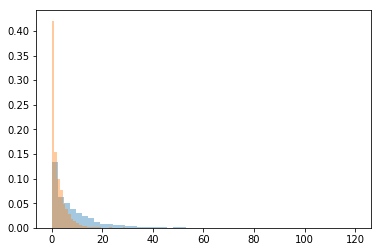

steps: 310 	 loss: 6.3206658485
new best: 6.02873460809345
state: [0.33125174866016605, 0.32154395179853607, 0.30286686303853294, 0.3390862380204272, 0.3374663424080244, 0.30820358374083173, 0.30308215110038705, 0.3328813878008024, 0.3279219939567073, 0.33283246144079615, 0.20555826404707228, 0.28644408330819626]


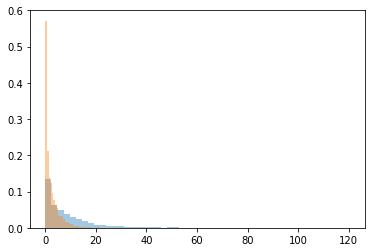

steps: 320 	 loss: 6.33524346866
new best: 5.975567020581138
state: [0.3296234572840979, 0.3252548171474376, 0.2996099524866631, 0.34373628896199243, 0.3341176248210517, 0.30796368330589946, 0.30591103211660625, 0.33301673830436285, 0.32570526676504996, 0.3362737107297811, 0.2013998564670727, 0.28123613488319]


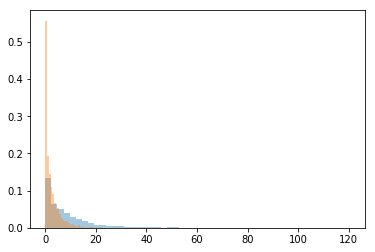

steps: 330 	 loss: 5.99521538812
new best: 5.894957305347992
state: [0.3279642677712328, 0.32340984052433364, 0.29944218853103255, 0.34643530436146436, 0.3340122767762383, 0.30319899713346044, 0.3038548046025816, 0.3346600855739588, 0.3266545612594154, 0.3370941329230285, 0.2001613444069655, 0.28423203292933474]


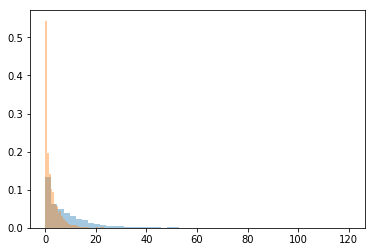

new best: 5.878705137294304
state: [0.32815996545747, 0.3230880196123439, 0.298916374391152, 0.348621776356672, 0.333168622063217, 0.3008275762262301, 0.30613121888133604, 0.3344303978403215, 0.3262629520551061, 0.3353773696342892, 0.19525850866168126, 0.28089016780640996]


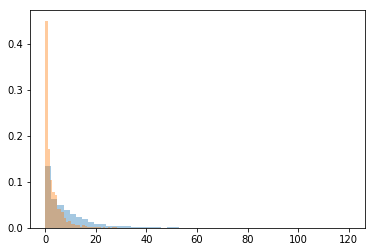

new best: 5.829329211623469
state: [0.32952915310743186, 0.32364146903767665, 0.29835541963103135, 0.34821130046524185, 0.3316308468335344, 0.30147596048244674, 0.3053780009351693, 0.3341074158987735, 0.3280402235543886, 0.3348602419862857, 0.19405836918553976, 0.2802247960330729]


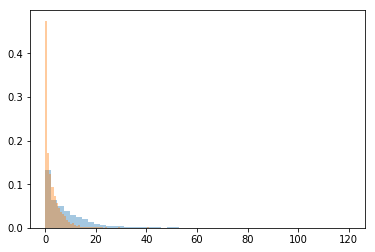

new best: 5.790637819679047
state: [0.3288773715106877, 0.32422271748931425, 0.29988942632174603, 0.3472020924971661, 0.331404868683091, 0.301440698083394, 0.30610277749832243, 0.3346562159593527, 0.3281457563879476, 0.33565049368022254, 0.19218460946824326, 0.27851816737938545]


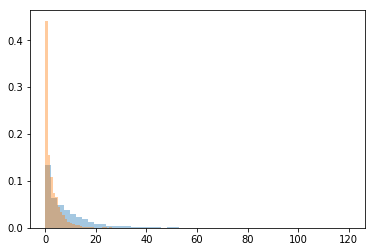

steps: 340 	 loss: 5.79063781968
new best: 5.77024796103231
state: [0.3270590373359184, 0.32423343956744144, 0.30045095387863635, 0.34701215779956335, 0.3307037184684847, 0.30060878578021644, 0.3055597738730619, 0.33364122343220265, 0.32830582710310885, 0.33585368450710545, 0.190981456045756, 0.27830856680610977]


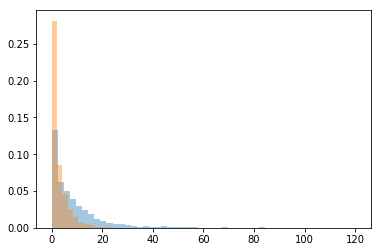

new best: 5.728892002927781
state: [0.3244773869024402, 0.3256186431452447, 0.2971666891398737, 0.34754902898280415, 0.3304528525436054, 0.3009858900973806, 0.3068398667195397, 0.3352377339218904, 0.32989570286898756, 0.3360379778993865, 0.1883700539779351, 0.277350373171961]


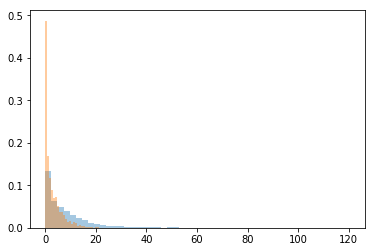

steps: 350 	 loss: 5.8185415732
new best: 5.7280760796575105
state: [0.3249603879429047, 0.32575074428855705, 0.2989858782896908, 0.34843142544837363, 0.3289373032170241, 0.3015797482364559, 0.3067251497990922, 0.3359695988192044, 0.32775032067944965, 0.33528193201368345, 0.18394318350780187, 0.27911101075431805]


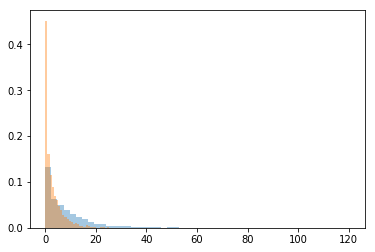

new best: 5.406911067476365
state: [0.32441355470087024, 0.3252624425713146, 0.2995320693937101, 0.3481522414772254, 0.32754478406331095, 0.30422854631896695, 0.3067106024315844, 0.33354328149101586, 0.3284837693886663, 0.33793525125265644, 0.18161616710786943, 0.27798025662950215]


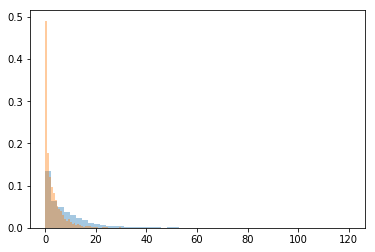

new best: 5.3632431401619
state: [0.3255043878541379, 0.3272340476011741, 0.29877945850082266, 0.34594192400169427, 0.33053292873195567, 0.30316115517133746, 0.30876590670479415, 0.3331356066810742, 0.3280741666207271, 0.3372658424529826, 0.17979643328056114, 0.2793855030500812]


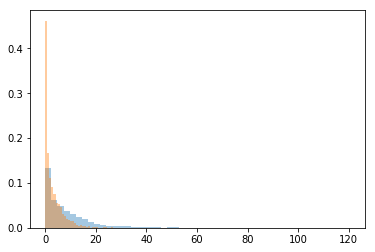

new best: 5.208680293356895
state: [0.3257763167823688, 0.3265777407608318, 0.29910223470903186, 0.3430203743558314, 0.33189455778402155, 0.3005774364250223, 0.31142377213977884, 0.332743176031072, 0.32612819115743774, 0.33602390158556367, 0.17849266720780269, 0.2828342107029863]


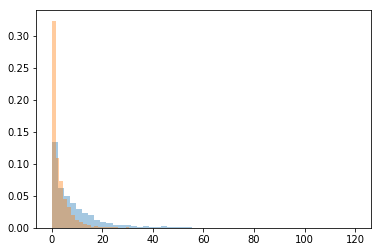

steps: 360 	 loss: 5.78322571803
new best: 5.150332042837038
state: [0.32997022378394775, 0.3286190288166157, 0.3005895268558349, 0.3463650769261296, 0.33080343956251573, 0.2990883080251815, 0.31330717764987154, 0.33429802499188355, 0.32848032668885413, 0.3381210261753774, 0.16943652156757769, 0.28387657354726675]


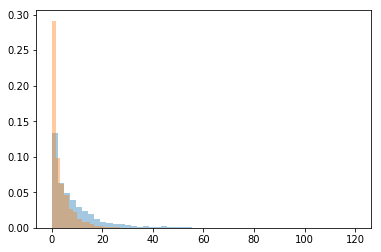

new best: 5.037132907189323
state: [0.32982895251432837, 0.3275440097504328, 0.3006607390762992, 0.34614994366963203, 0.329630346870755, 0.29974860987208396, 0.312268626862348, 0.3334862844806811, 0.3275087597774308, 0.33753572514215313, 0.16948852980105816, 0.2851869776028462]


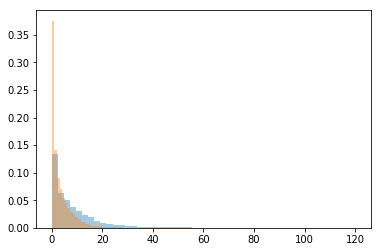

steps: 370 	 loss: 5.52704118048
new best: 4.796463658630195
state: [0.3280292951227372, 0.32677051247352895, 0.3016740957274596, 0.3442123512510675, 0.3267726489129449, 0.3008996427210333, 0.30962371956980067, 0.3361649416508597, 0.3265151583875098, 0.33973228661411176, 0.16537755285237798, 0.28351770911362834]


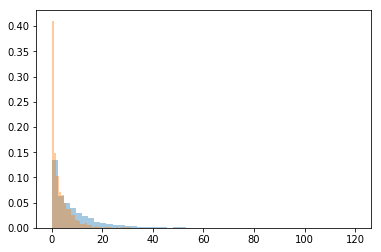

new best: 4.245868951880886
state: [0.32917005408325595, 0.3298090570263426, 0.3046972192562168, 0.3458214745124132, 0.32886536150609685, 0.2998413260969323, 0.31231283200789606, 0.3323971655484502, 0.3240380882624606, 0.342446774421259, 0.16333011634085434, 0.28669699527663534]


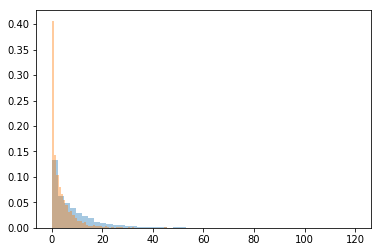

steps: 380 	 loss: 4.49721302367
steps: 390 	 loss: 5.0540125638
new best: 4.238244117021868
state: [0.3329401502404649, 0.33912859467135986, 0.3060713203338863, 0.34928255486057247, 0.33040687992884693, 0.2914654712674743, 0.31393124448793036, 0.3323220799007361, 0.3241266558939066, 0.341113059564757, 0.14936165582163613, 0.2820895867079998]


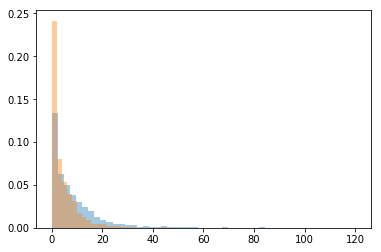

steps: 400 	 loss: 4.23824411702
new best: 4.073718024716163
state: [0.33254646962989776, 0.3394180719912713, 0.3045859038234104, 0.3495825221764892, 0.33028600273725145, 0.29136079579876245, 0.3133074602640708, 0.3321777189858557, 0.3247352735373452, 0.3420511741927253, 0.1478971134964652, 0.28128922194116673]


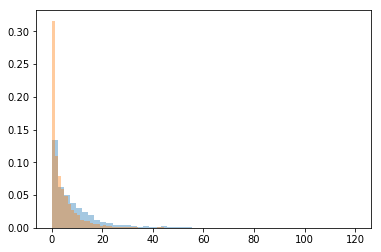

new best: 3.870173663676387
state: [0.33378844041141614, 0.34030787669989393, 0.3073761700676664, 0.3503348161870863, 0.3310802325147983, 0.29431565525586484, 0.311963773402226, 0.3317667788486651, 0.32492562189459334, 0.3364316734678002, 0.1420827202713817, 0.28135547963303437]


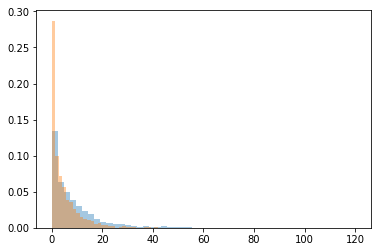

new best: 3.7168444721189986
state: [0.3336085151926858, 0.33949015928313747, 0.3072377777811094, 0.35150203977314926, 0.33189581506460714, 0.2966211344240427, 0.30954076336141884, 0.3312238379789887, 0.3274316763414923, 0.33579245129195295, 0.1363072424943785, 0.28116260402204674]


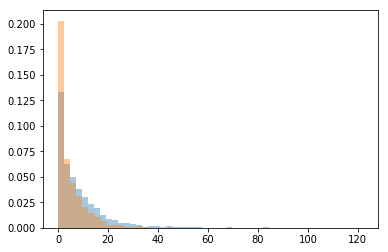

steps: 410 	 loss: 3.97746845509
new best: 3.3675873275944816
state: [0.33448290595861285, 0.3375395660631107, 0.3078088724986129, 0.35210730788033917, 0.3330067956042863, 0.2937621708902614, 0.3134174853503394, 0.3300568030685689, 0.32723030157190197, 0.3370214390248034, 0.13597097728565694, 0.28317208351959666]


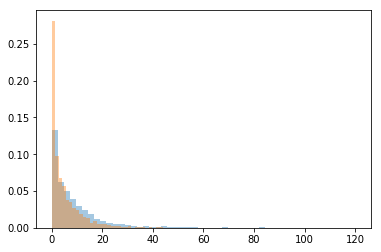

new best: 3.2685650052756383
state: [0.3334746079421944, 0.3405231768823336, 0.30729473525492135, 0.34934987172780746, 0.33388749714919885, 0.2909945748912585, 0.3167279934368806, 0.3302323820110194, 0.3269784432516288, 0.3396967943231243, 0.13256935474970774, 0.2822722116695863]


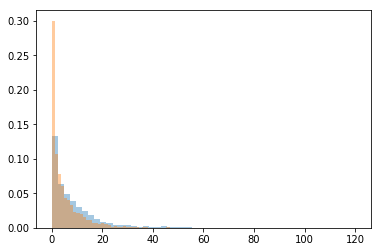

steps: 420 	 loss: 3.39353738411
new best: 3.203786546949841
state: [0.3326444443754393, 0.33953175384406836, 0.30407948127776857, 0.3526240190393756, 0.33745297732028473, 0.2939476419179404, 0.31807505112071155, 0.3352324274009534, 0.3251024382456247, 0.335930784829232, 0.1271068058777873, 0.28304441268939345]


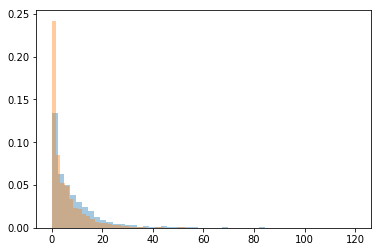

new best: 2.8268104299229595
state: [0.3332296867072004, 0.3391960360348083, 0.30274347171653226, 0.35344113011177863, 0.336814450557013, 0.29186363779180075, 0.3177106806323504, 0.33528998104576685, 0.3258623206515263, 0.3358623663829213, 0.1270918678707947, 0.2830199286466287]


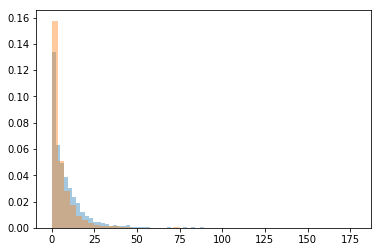

new best: 2.3175567736791987
state: [0.336314836815207, 0.336765699258004, 0.30424223512898735, 0.35326222522717166, 0.3373335991204119, 0.2895365572012544, 0.3187869919942807, 0.3352468758508098, 0.32619430912001557, 0.3381056595790113, 0.1250968953577205, 0.2854562301342917]


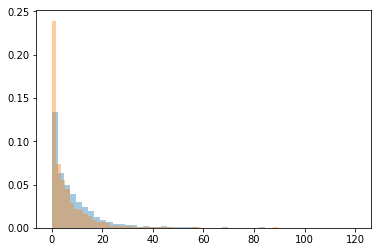

steps: 430 	 loss: 2.8573631428
new best: 1.8954341739485125
state: [0.3387524988633205, 0.3355022593874096, 0.3039412460833678, 0.3557042239006768, 0.3314852577094864, 0.2938555628774697, 0.3165296175119644, 0.3357503848417501, 0.32597936405459477, 0.33660008470452846, 0.12363805197516979, 0.2785526818725279]


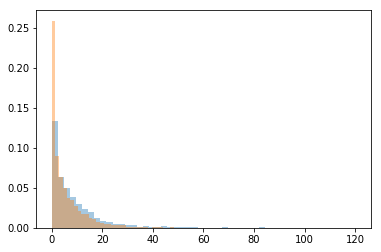

steps: 440 	 loss: 2.97694913929
new best: 1.7547645797402793
state: [0.3375315064040196, 0.3341800048403243, 0.30828658985588886, 0.3568502577167995, 0.33439679419344825, 0.2970758578512703, 0.31770756633106134, 0.3368356184552639, 0.32325088642338023, 0.33445370736438984, 0.11832785704105303, 0.2721901003851668]


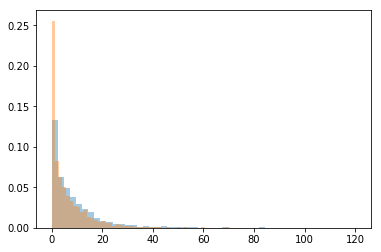

new best: 1.6672751383516191
state: [0.34311474577039514, 0.3357529327841293, 0.3097492224622015, 0.3568711332651134, 0.33686125354875346, 0.29782057817981533, 0.31969582757621523, 0.33401873164283913, 0.3295838608998178, 0.33453543986234563, 0.1168852954172432, 0.27026099857000163]


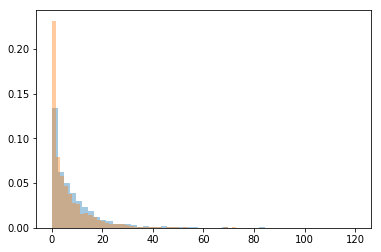

steps: 450 	 loss: 1.66727513835
new best: 1.6400114970991773
state: [0.34246410593823745, 0.3357826083644763, 0.3080238687579864, 0.3543288428521025, 0.33657564872795215, 0.29848645286053815, 0.31974526242247947, 0.33372564628742873, 0.32696356457486586, 0.3339870366311485, 0.11458874698275993, 0.26825926900852626]


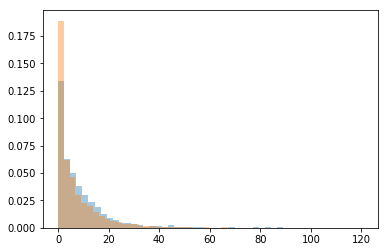

new best: 1.157503960861517
state: [0.34392538349577767, 0.33501214687785774, 0.3076932642912956, 0.35268040682948565, 0.3356687352512917, 0.30025663884714104, 0.3176106324307199, 0.32872740468743555, 0.3263657556276855, 0.3341798123845197, 0.10887599904912611, 0.2697542795004673]


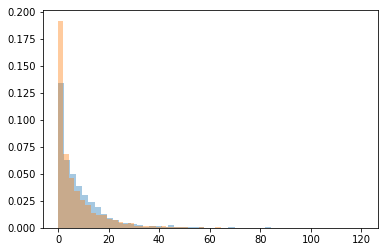

new best: 0.9728389549909242
state: [0.34582790143663583, 0.33315485134943384, 0.30644885436861763, 0.35016077055325934, 0.3371467331481185, 0.2969370114434638, 0.3198257358226395, 0.32795481116248637, 0.3290151025336663, 0.33514991678428485, 0.10404212458652165, 0.268547001511387]


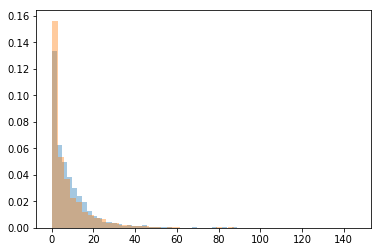

steps: 460 	 loss: 1.09564320177
new best: 0.9375155756269261
state: [0.34379067784926587, 0.33316327997301237, 0.3080568423847669, 0.35089316699673956, 0.33304793953752765, 0.2982501633120868, 0.3183998254042881, 0.3264851086407389, 0.32858939707210183, 0.3350796464822266, 0.10061639932630706, 0.26624258168251147]


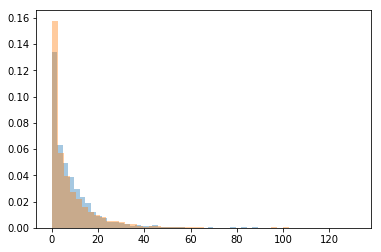

steps: 470 	 loss: 1.16775954236
steps: 480 	 loss: 1.0290884343
new best: 0.7720387459917242
state: [0.34233302920229247, 0.32715653095184144, 0.30282302725501614, 0.3501158414623263, 0.3341467102022932, 0.29577565239770015, 0.31657507850077654, 0.3259581667490047, 0.32659242208532685, 0.3402814317140851, 0.10012965734528506, 0.2610421987658103]


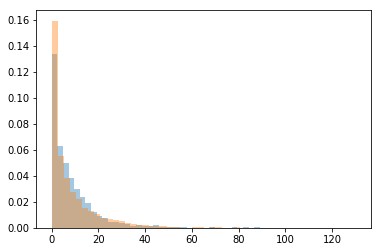

steps: 490 	 loss: 1.08970351761
steps: 500 	 loss: 1.0937665043
steps: 510 	 loss: 1.02156584238
steps: 520 	 loss: 1.40091662005
new best: 0.7692044364989366
state: [0.3409206621287661, 0.32298177552872354, 0.3051087099059809, 0.3458380867499862, 0.33592450890103676, 0.3017742441602269, 0.30621976457773736, 0.3307412716133101, 0.3260023478670938, 0.33926006528262254, 0.10170511601510789, 0.2606978411702307]


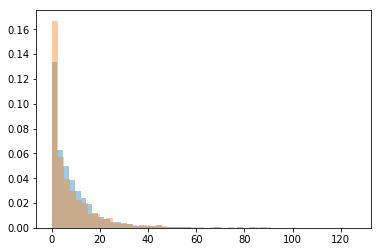

steps: 530 	 loss: 1.25260957857
steps: 540 	 loss: 1.07343457154
steps: 550 	 loss: 1.18893744214
steps: 560 	 loss: 1.22218510162
steps: 570 	 loss: 1.46172995612
steps: 580 	 loss: 0.933509221626
steps: 590 	 loss: 0.971085267823
steps: 600 	 loss: 1.09736606724
steps: 610 	 loss: 1.01630716704
steps: 620 	 loss: 1.30283655574
steps: 630 	 loss: 1.17932381205
steps: 640 	 loss: 1.24170246446
steps: 650 	 loss: 2.03742163309
steps: 660 	 loss: 0.958195455372
steps: 670 	 loss: 1.18660174959
steps: 680 	 loss: 0.99805995694
steps: 690 	 loss: 1.05560848679
steps: 700 	 loss: 1.06337099126
steps: 710 	 loss: 1.11325307966
steps: 720 	 loss: 1.16344239201
steps: 730 	 loss: 1.18033926788
new best: 0.6869612627216328
state: [0.3412680412299144, 0.3280676064020609, 0.3123512655778022, 0.33884578474178867, 0.34569326352464363, 0.3089058534186534, 0.30665575927934885, 0.32833319416301116, 0.3292095331761279, 0.3448308215662101, 0.100554729248167, 0.253388319955202]


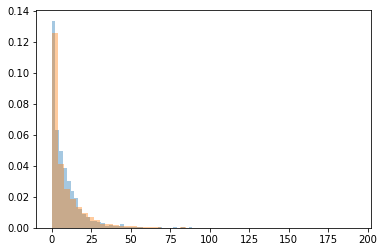

steps: 740 	 loss: 0.686961262722
steps: 750 	 loss: 0.851172311023
steps: 760 	 loss: 1.02739568225
steps: 770 	 loss: 0.932849499435
steps: 780 	 loss: 1.61374028888
steps: 790 	 loss: 0.873173345311
steps: 800 	 loss: 1.6007744328
steps: 810 	 loss: 0.902140918626
steps: 820 	 loss: 0.850676775317
steps: 830 	 loss: 1.11864112502
steps: 840 	 loss: 1.14602796863
steps: 850 	 loss: 1.7969642326
steps: 860 	 loss: 1.09971966879
steps: 870 	 loss: 1.30378484484
steps: 880 	 loss: 1.02812959203
steps: 890 	 loss: 0.852546460285
steps: 900 	 loss: 0.90005374744
steps: 910 	 loss: 1.55388310368
steps: 920 	 loss: 1.06746731381
steps: 930 	 loss: 1.11204216608
steps: 940 	 loss: 1.01457457484
steps: 950 	 loss: 0.966761281239
steps: 960 	 loss: 1.04887184186
steps: 970 	 loss: 0.976525636534
steps: 980 	 loss: 0.87301719181
steps: 990 	 loss: 0.902173730462


In [3]:
gradient_descent(initial_vars(10), gradwidth=.01, lr=.0001, logplot = False)  

# Systematic Calabi-Yau Data

In [5]:
CY_eigs = {
          10: np.loadtxt("KS4/h11_10_eigs.txt"),
          20: np.loadtxt("KS4/h11_20_eigs.txt"),
          30: np.loadtxt("KS4/h11_30_eigs.txt"),
          40: np.loadtxt("KS4/h11_40_eigs.txt"),
          50: np.loadtxt("KS4/h11_50_eigs.txt")
          }

new best: 9.335351902812436
state: [0.31622776530079577, 0.3162277671412899, 0.3162277665859924, 0.3162277658712597, 0.3162277698485485, 0.3162277681510991, 0.3162277656185072, 0.3162277663320683, 0.31622776673935127, 0.3162277666835251, 0.31622776270114095, 0.316227765958139]


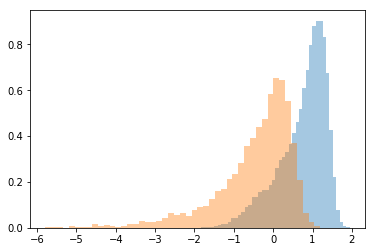

steps: 0 	 loss: 9.33535190281
new best: 9.246523789654987
state: [0.3135309783353648, 0.31684398627376226, 0.3092794884234034, 0.3124100718454809, 0.3206191113870368, 0.3194175796396043, 0.31358808376458464, 0.32039151593919873, 0.31845963015076556, 0.3196396742802555, 0.3143582874061477, 0.31623673592843776]


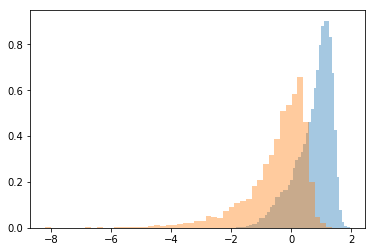

new best: 9.2218556796748
state: [0.31409146112100644, 0.31733395528889796, 0.3055650042442892, 0.31027483901096103, 0.32132386917484007, 0.31931765747539126, 0.313557921801099, 0.32212937413664167, 0.3213114444646386, 0.3209834610605811, 0.3132850179817434, 0.31484246598600724]


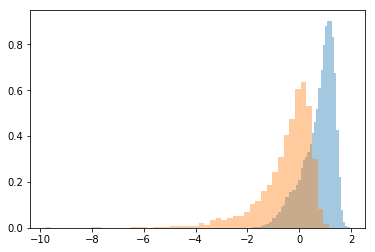

steps: 10 	 loss: 9.28393199325
new best: 9.180632312471603
state: [0.3102997341007318, 0.31519509957298586, 0.3099777783073908, 0.31218504060301966, 0.31766556787339534, 0.3249744096847154, 0.311560764590434, 0.3191942878551635, 0.3205775591750702, 0.3290047538913564, 0.3072506502305071, 0.31395306338393814]


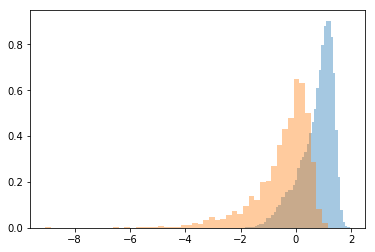

new best: 9.174484353201613
state: [0.3099914085139, 0.3161818496034562, 0.31053670369040476, 0.3125701984195932, 0.3191700604092209, 0.32628058190559706, 0.30978339611382805, 0.3212228064932907, 0.32299872612568886, 0.3326705078428968, 0.3046070797416921, 0.31284196213524296]


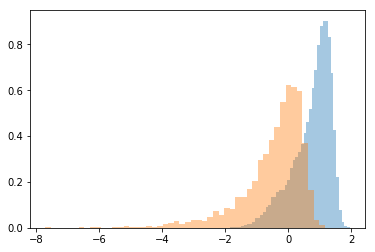

new best: 9.130107592928187
state: [0.3069811989951302, 0.31928828854449354, 0.302374366215856, 0.3045638504763381, 0.3235299259306882, 0.32815060114914096, 0.3121559372407038, 0.3182547011088531, 0.316923997336814, 0.33619992125218573, 0.3057664000373185, 0.3107772955335178]


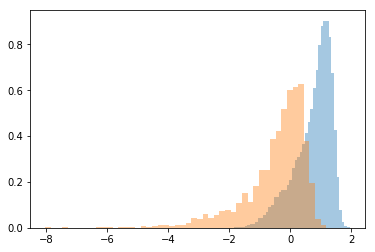

new best: 9.01525993819331
state: [0.3181326495741941, 0.3191253066189684, 0.3007450238069168, 0.31084178888676206, 0.33258110095845655, 0.32492435058908303, 0.3160901578570027, 0.3160765284249692, 0.31599929648562053, 0.33654204369801227, 0.2982595632495212, 0.3038285560907353]


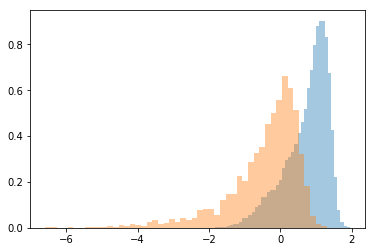

steps: 20 	 loss: 9.01525993819
new best: 8.971382220735753
state: [0.31441653107268247, 0.3201619745727003, 0.301098923070714, 0.31376334877044165, 0.33712110349168606, 0.3219477778101164, 0.31612699173515557, 0.3163154629222165, 0.31927559313420245, 0.34613793388915925, 0.2902522545259335, 0.3044139158518096]


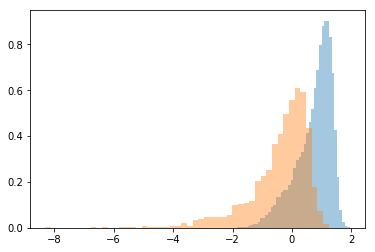

steps: 30 	 loss: 8.98988788618
new best: 8.68284185094176
state: [0.31036671273278066, 0.31646378351186394, 0.3217010582851936, 0.31652767950070687, 0.33870245303394475, 0.31780277680946306, 0.3108576250592301, 0.3089265633231902, 0.31946447253530524, 0.34524174130227203, 0.26929746761998413, 0.3016530293939658]


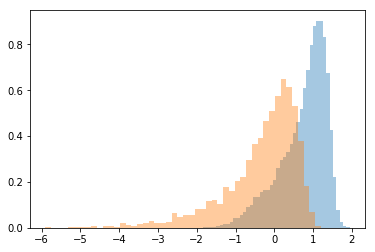

steps: 40 	 loss: 8.8219805133
steps: 50 	 loss: 8.93595421933
steps: 60 	 loss: 8.93171175237
new best: 8.661776606179513
state: [0.29311265085817, 0.3141592249375434, 0.3384091700775065, 0.31984554343142413, 0.3307006562986501, 0.3059351865165649, 0.31942285996179703, 0.3168192375657562, 0.329054067346703, 0.33866979803569197, 0.25200585110490853, 0.3000179825349193]


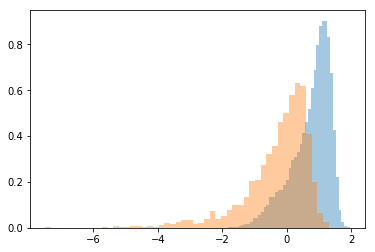

new best: 8.51407086801591
state: [0.2936912958792852, 0.3133098933404308, 0.33912084393358227, 0.31832023902556456, 0.3304735053227063, 0.3070262626547577, 0.31737084172844743, 0.3199532098168372, 0.3291580932449004, 0.33700531450569393, 0.2511672141480101, 0.29887577466592014]


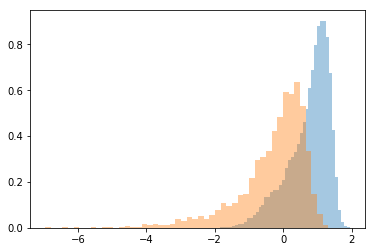

new best: 8.512441931143705
state: [0.2943067103231496, 0.3086113047186252, 0.33746550267886627, 0.31818365429533363, 0.32914862798999417, 0.30747674680573067, 0.3135009342632309, 0.31771830916519833, 0.32916183645947605, 0.33629748626701694, 0.2403971956159736, 0.301599848339204]


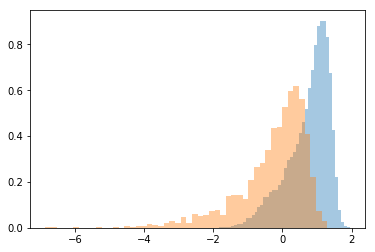

new best: 8.488957451426598
state: [0.29950275515847646, 0.3071351140242722, 0.33761470002625926, 0.3187102705099549, 0.32732743521372504, 0.30848261201349864, 0.31234307293980834, 0.3238502622268586, 0.3277187324843949, 0.33072217518273317, 0.23632568737976548, 0.29663332313312907]


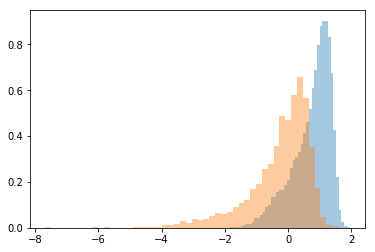

steps: 70 	 loss: 8.48895745143
new best: 8.48870069947425
state: [0.30481630318368574, 0.3043362856071659, 0.3345386063704045, 0.32201570769492377, 0.32567191782835636, 0.3069092391537946, 0.31616224250186675, 0.3241112639616274, 0.32846895371330226, 0.3297322498353533, 0.23738010783808558, 0.29702054836142566]


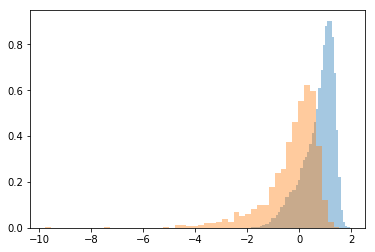

new best: 8.482696042099521
state: [0.3060783992443355, 0.3044965704809678, 0.3356550908658277, 0.32127751907083346, 0.3246297498470072, 0.30672574718524975, 0.31864791206796017, 0.3244952210725185, 0.32747981778979546, 0.3249151457225789, 0.23413346092351556, 0.2980780180783]


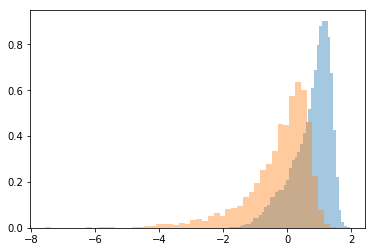

steps: 80 	 loss: 8.49023762275
new best: 8.32630416889622
state: [0.30405503916377324, 0.309258369132831, 0.33428897604409635, 0.3266227143554277, 0.3290032596203526, 0.3063683823850079, 0.3209510885405166, 0.32282151228356476, 0.3254687566190369, 0.3206474294043544, 0.2301056116801251, 0.30525012310111715]


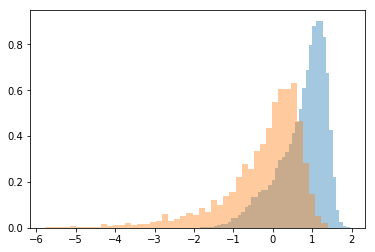

new best: 8.214032415121947
state: [0.3035836795077717, 0.31382399565006436, 0.3429125681425771, 0.32868909154363135, 0.3328462878118844, 0.30138588287340246, 0.3303901051841321, 0.32305707674898926, 0.33179255573866273, 0.3220978479517619, 0.21955221223840865, 0.3055104915909199]


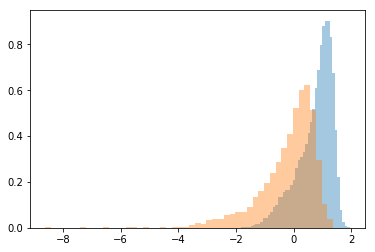

new best: 8.072531386154088
state: [0.3042603799167742, 0.31328206784276985, 0.3426742805038868, 0.3301879938989452, 0.33314949241255165, 0.3042473375218714, 0.3307602690058014, 0.32089517642932075, 0.33422670253510717, 0.32244675028869696, 0.2208420817536938, 0.3042340322043734]


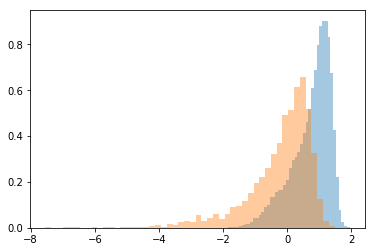

steps: 90 	 loss: 8.22551615293
new best: 8.029940184197093
state: [0.3070025217473083, 0.3167368725982632, 0.33878098599082207, 0.3328600196732427, 0.33688919792489475, 0.30442407698537427, 0.3300889127742212, 0.3233151769125044, 0.33654406815275767, 0.3229899771543473, 0.21642436969077156, 0.304053834581243]


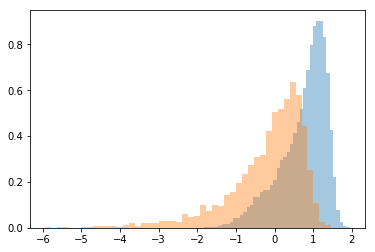

new best: 8.022330565959246
state: [0.31246038629319006, 0.3198040076250326, 0.3360095310002725, 0.33275238605249263, 0.3372345287741706, 0.3073028718984998, 0.32896061402000754, 0.3174673762814552, 0.33538677840385206, 0.3245123546725502, 0.20648358346782864, 0.3033217375525271]


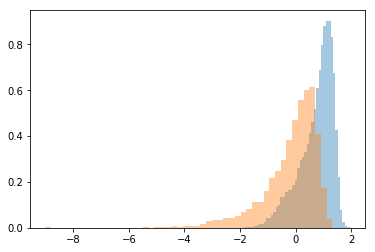

new best: 8.01830813907705
state: [0.3140931554603973, 0.31934968979947154, 0.3361957930524924, 0.33045471794036246, 0.33742502832504584, 0.30577733824508824, 0.32563725377708197, 0.318414492892965, 0.3343327661900477, 0.3250268543714131, 0.20852828638353302, 0.30726912741029366]


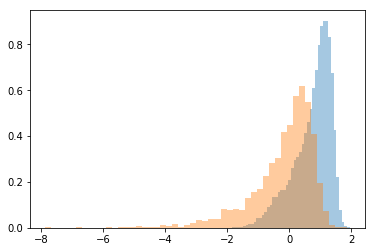

steps: 100 	 loss: 8.06164601266
new best: 7.9171833375358736
state: [0.3142420891627916, 0.3173357381254782, 0.3357965684991957, 0.32626117513287106, 0.33906176197804133, 0.30624968493108723, 0.32603627617968134, 0.3178480784687688, 0.33134290646994896, 0.31872121278709536, 0.20169499137962849, 0.3055772261750523]


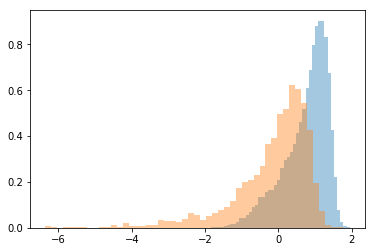

new best: 7.845590985905641
state: [0.31515752554114695, 0.32052455430225224, 0.3362846885477371, 0.32679935426833473, 0.3393358201124555, 0.30774871922680597, 0.32649360189657395, 0.31633345309401245, 0.33024773282443404, 0.31911787514609596, 0.20311050170847658, 0.3052068896468479]


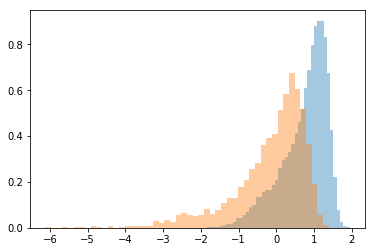

new best: 7.772978430530155
state: [0.3140195749538093, 0.3191176354321811, 0.3347858740609017, 0.324483961228932, 0.33821908406338275, 0.3076221010555427, 0.3242202583540532, 0.31260647784272716, 0.33169205578437, 0.3182871492696426, 0.19940530143059676, 0.30610123790124666]


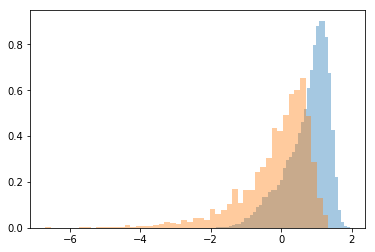

steps: 110 	 loss: 8.12623882358
new best: 7.71842977293122
state: [0.3171349427155861, 0.3155050695188863, 0.3343114260031282, 0.31970649387437616, 0.33870683565220416, 0.3052904917258369, 0.32540728922945783, 0.3146234375380554, 0.3411336962217872, 0.32758884454550746, 0.19818544493368234, 0.3005526120538423]


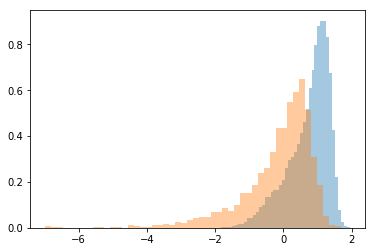

new best: 7.7011406150028785
state: [0.31718901132923033, 0.30982315645727065, 0.3403463456948689, 0.31839057460863157, 0.33720893129510127, 0.30053166423828026, 0.32642277565455924, 0.3154065419545197, 0.3421195905404597, 0.32438143461578783, 0.19790302771688653, 0.2981857374947263]


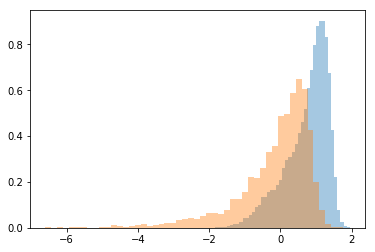

new best: 7.658687647547327
state: [0.3145274240806017, 0.30674121856507297, 0.3450199257800252, 0.31921628788485573, 0.33601359162583705, 0.2933051172867021, 0.3274905250580928, 0.3147897142420521, 0.3414228844201798, 0.3209460265704559, 0.19216688396715567, 0.29881671890251377]


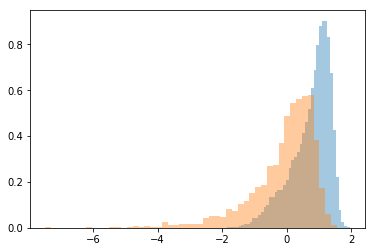

steps: 120 	 loss: 7.65868764755
new best: 7.492396283735511
state: [0.31339406553271176, 0.30632240918164194, 0.34871133667078624, 0.3198203158494882, 0.33214779134797756, 0.2933281414568469, 0.3232999175706157, 0.31259733974749415, 0.34426305560924764, 0.3228847719689263, 0.18787128658973265, 0.2977379875466394]


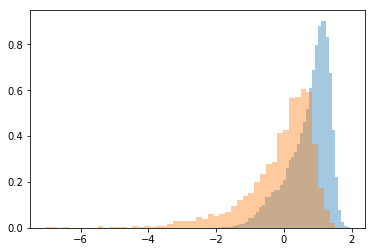

new best: 7.209810803051135
state: [0.321719684054257, 0.3024460908141368, 0.35098158036372085, 0.3220530495072726, 0.33673269853304433, 0.29376911523685484, 0.3262432583304977, 0.3130037070817257, 0.34515699551177004, 0.3142523299993892, 0.18070967343120511, 0.2950299115510968]


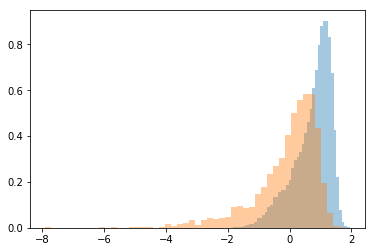

steps: 130 	 loss: 7.57414592726
new best: 7.126018268423615
state: [0.3279380737148237, 0.306178442656509, 0.35091171416852374, 0.3206098067101025, 0.3363867366658534, 0.29218059307166144, 0.32981086545219307, 0.3081063573538115, 0.3472796029084138, 0.30677552222930865, 0.17307939524720348, 0.29933477362090744]


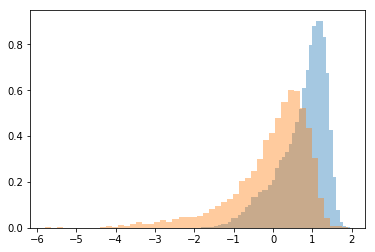

new best: 7.108860653765555
state: [0.33026240664657175, 0.30726633229563577, 0.3474826829394781, 0.31966370923320286, 0.338317263954555, 0.29333325764123236, 0.33632363619015637, 0.30212820025594905, 0.34187977542082215, 0.30758081779071084, 0.17158503240045248, 0.2944175481782615]


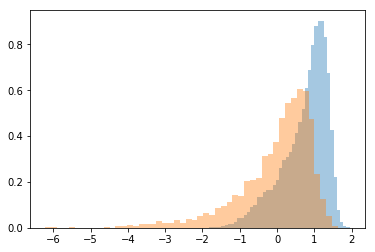

steps: 140 	 loss: 7.36165669883
new best: 7.103640150016193
state: [0.33136155948450147, 0.3085612422540746, 0.34971627144579953, 0.3196751069021819, 0.339058649347992, 0.29661580220215145, 0.3349063516437247, 0.30008718566238285, 0.34044704111840407, 0.31018950660831407, 0.1706278641868932, 0.2962412302609802]


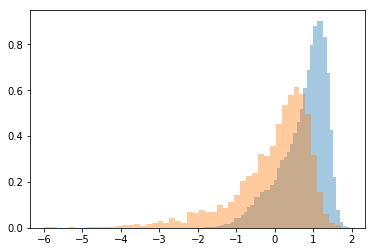

new best: 7.0480549937368435
state: [0.32183097673384536, 0.30813678354585555, 0.34323384429228887, 0.3224578274778329, 0.339903424036089, 0.2936402623130576, 0.34072595038018605, 0.3009173680622033, 0.3431386180411896, 0.3145592393461908, 0.1644771148789273, 0.2953074548633807]


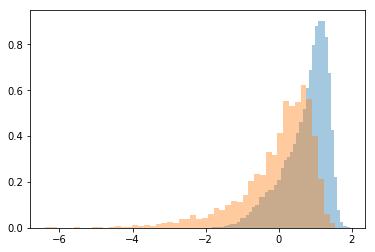

new best: 6.735725532410519
state: [0.32071655861460663, 0.3109062715394367, 0.3429788181139433, 0.32233312712364914, 0.33778213498812687, 0.2977714668533176, 0.3415203400670677, 0.30136029649475293, 0.3430289659015827, 0.3184137552480835, 0.16132877608369417, 0.29230542710853685]


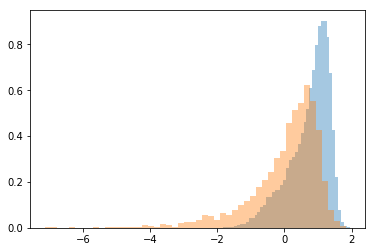

new best: 6.578335954645571
state: [0.3193467139459861, 0.3114795904560229, 0.34187705295931736, 0.32208570206326614, 0.33785343663946127, 0.2960856096619515, 0.34121382638229236, 0.3022668548677253, 0.34511715298779216, 0.3173572491538949, 0.16086935115217585, 0.2915883831992776]


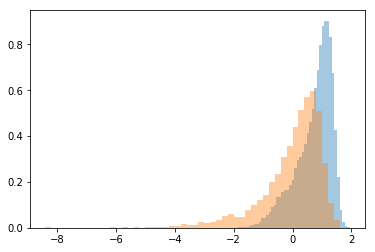

steps: 150 	 loss: 6.63332507988
new best: 6.264338495958634
state: [0.32376126261316673, 0.31257690198625454, 0.33799979296533766, 0.32362224164234527, 0.34726660907476997, 0.2937257977696128, 0.34160588355150073, 0.3027196620541621, 0.3485493413939136, 0.3153110477541705, 0.15214253986807916, 0.2941012966880304]


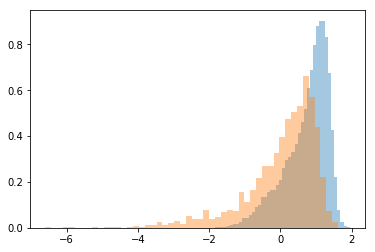

new best: 6.238712176333167
state: [0.3239299420362666, 0.3156807870913994, 0.338157871755058, 0.31892972833914607, 0.3495771969779376, 0.28986494764734716, 0.33712768575615704, 0.2996938149123826, 0.347979285008784, 0.31346166309585627, 0.14966269197503004, 0.29487959733121116]


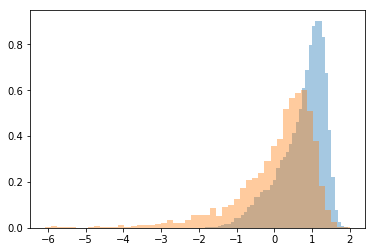

new best: 6.167755755270155
state: [0.3218820881071895, 0.3153809929155908, 0.336945107872002, 0.31987760000995724, 0.3507447743445359, 0.2904739161180224, 0.33859249853673334, 0.30251255273339095, 0.3478738190842084, 0.31461839324087654, 0.1476182993714258, 0.2946371572505844]


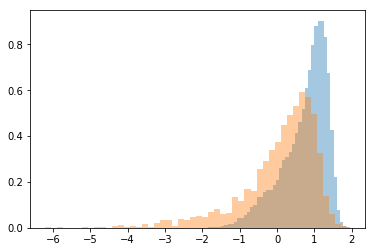

steps: 160 	 loss: 6.45313651671
new best: 5.6816835013965
state: [0.322872622920181, 0.31468909508281495, 0.3306487729928842, 0.3244402536897076, 0.3501722551294006, 0.2883692685664391, 0.33579580186059677, 0.30801665833991176, 0.349461981817548, 0.31363550445595834, 0.14256389972921127, 0.2957080473826406]


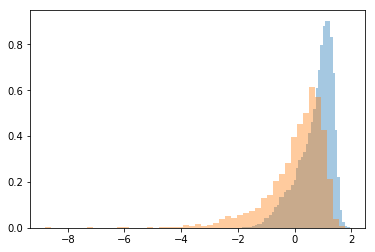

new best: 5.597794490283371
state: [0.32339008095182475, 0.3131660843770098, 0.3326877129778397, 0.3256328589495614, 0.34964380791739397, 0.2872600985778265, 0.3363120951634516, 0.3072754880119254, 0.34793737971308686, 0.31277999561731434, 0.14326704102906557, 0.29547710581238595]


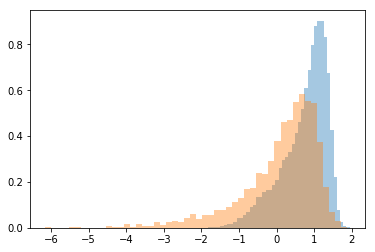

new best: 5.469460915609451
state: [0.32820366936152984, 0.3096931905929502, 0.334806029934145, 0.3320282684097434, 0.35173573055943796, 0.2879284868906939, 0.3390537902957891, 0.3119533713328459, 0.3507730309987202, 0.3144402688342789, 0.1408809836124388, 0.29540459734971924]


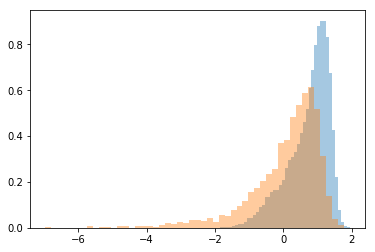

steps: 170 	 loss: 5.70267375635
new best: 5.343669301525558
state: [0.32881126122546417, 0.30829025011481037, 0.335423982313222, 0.3343492050514048, 0.3500186835325212, 0.29648139237418153, 0.34396905083566537, 0.31465358671776594, 0.3554767181235186, 0.3151693185952446, 0.1371398725747178, 0.2981864017522956]


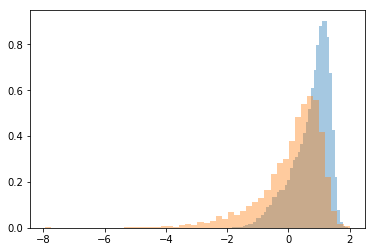

new best: 5.19469513034793
state: [0.33149223783717136, 0.30709772838906263, 0.33575724271899926, 0.33521046599775395, 0.3497592412769676, 0.2955403477615617, 0.3420098127229405, 0.3154312210863976, 0.35613411529193667, 0.3168030888784965, 0.13772803859095098, 0.2979319827019562]


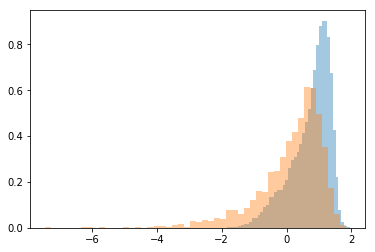

steps: 180 	 loss: 5.37105336652
new best: 4.8196157325326245
state: [0.32932572178052183, 0.3087947645746985, 0.33919811117037024, 0.3343781280175521, 0.35372972985195855, 0.29842552639538517, 0.3400228530307993, 0.32000987262192293, 0.3505616891745191, 0.3141062233144515, 0.12680660177232692, 0.29323067663768154]


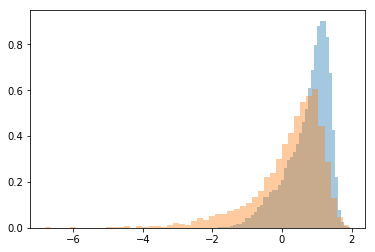

new best: 4.728198786236421
state: [0.32964291611511615, 0.3123466449544516, 0.3380678078160676, 0.33304615389960673, 0.35181807833585654, 0.2996748570174654, 0.3400773022578608, 0.3202978752534013, 0.34976132808076665, 0.3131442009233862, 0.12430461996447661, 0.2932184181543269]


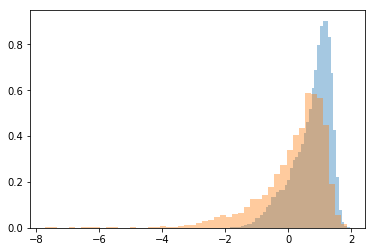

new best: 4.586499701591311
state: [0.3288497824316244, 0.31192199267675813, 0.3372186522387231, 0.3338219674696099, 0.35388108251224754, 0.2987423899330672, 0.33899673947428083, 0.3238769593241547, 0.3489803650422203, 0.3133637482467811, 0.12192282398089756, 0.29374916081720626]


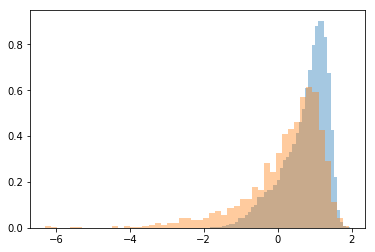

new best: 4.116061488873982
state: [0.32922205760943607, 0.31300326666920414, 0.3394919602189867, 0.3318031772179889, 0.35394624008125053, 0.2983336961622187, 0.33940807554005564, 0.32609047923702916, 0.34867042716765917, 0.31490982906318654, 0.1205092598134597, 0.29333814538850417]


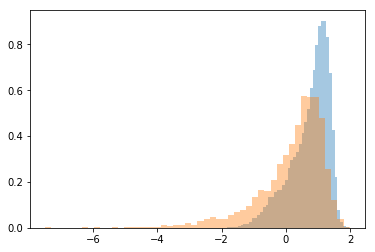

steps: 190 	 loss: 4.20639939248
new best: 3.9722533559237037
state: [0.32810346325098466, 0.3102069544394427, 0.3364057315652407, 0.32718659281412077, 0.35500957846480813, 0.29993365739126854, 0.334402857316141, 0.32902003919752565, 0.34500911001720674, 0.31545152345847294, 0.11295363587180868, 0.28942180450970406]


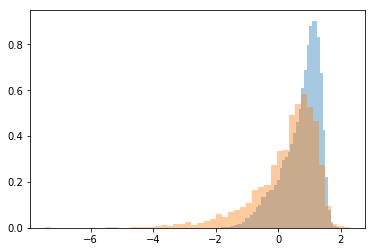

new best: 3.8532466054649595
state: [0.33314612683428413, 0.31301755988098845, 0.333745359426892, 0.32738648890753347, 0.3562916464453762, 0.3042928432587648, 0.3295906276073713, 0.33030708574424705, 0.34806100298719783, 0.31777352991062197, 0.11257416716984685, 0.29146659098423794]


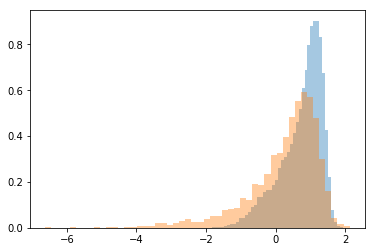

new best: 3.72545294417421
state: [0.3335547764556937, 0.3128562268704446, 0.33170505457167354, 0.33021296796437705, 0.3568074161414152, 0.3049867350334209, 0.33055093538626507, 0.3296404160855361, 0.3457055604132432, 0.3179160803176729, 0.1087369120879724, 0.29055327101241113]


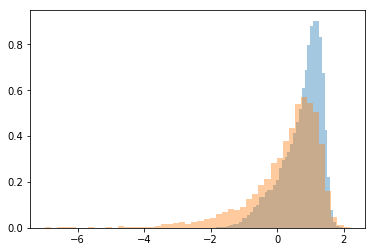

new best: 3.4514190013707533
state: [0.33139161048526633, 0.3126205135140756, 0.33122328208425583, 0.32985934695884356, 0.3563496128816107, 0.3059627420768535, 0.3297090701193331, 0.33118577713901537, 0.3469664712439019, 0.317857001792369, 0.10848014991482634, 0.29164158032817633]


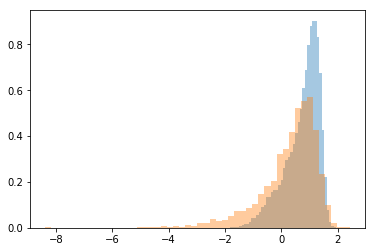

steps: 200 	 loss: 3.74682872544
new best: 3.311241070462013
state: [0.3272868131987312, 0.3173337235955664, 0.3336426849510216, 0.3255470190389113, 0.3563625781969341, 0.3114899451423095, 0.32230735469488164, 0.3311888824541831, 0.34537141502848206, 0.3180003331646087, 0.10500926779114127, 0.2896646641590505]


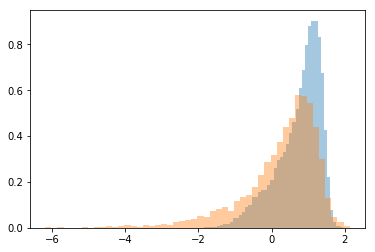

steps: 210 	 loss: 3.70914575423
new best: 2.8919572012152504
state: [0.3328660165240875, 0.3149546634997538, 0.3350801713942301, 0.3265494493834991, 0.35893588559904654, 0.3139789418929616, 0.3199393259129898, 0.3273494055132579, 0.34687656868655725, 0.31674021192703583, 0.10014811755121077, 0.2891791612124787]


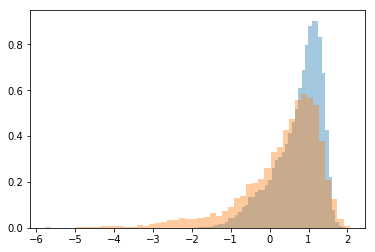

steps: 220 	 loss: 3.41603448296
new best: 2.829771798058823
state: [0.33242479394842717, 0.318417779117916, 0.330013420523629, 0.3273725042652219, 0.3591320156103908, 0.3140213126865929, 0.3195611144785118, 0.3258099155922672, 0.3482626897947564, 0.3154840346515722, 0.0967453844632287, 0.2875151578531616]


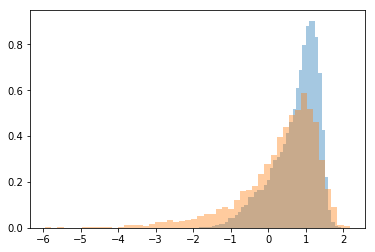

steps: 230 	 loss: 2.82977179806
steps: 240 	 loss: 3.69358791503
steps: 250 	 loss: 3.69830486157
new best: 2.7194304327077257
state: [0.3337105851252581, 0.3201906754166662, 0.3238164339993487, 0.3258035077716222, 0.35613863396927786, 0.3177185418183075, 0.3192888559458971, 0.329655339277771, 0.3416872164985902, 0.3190348490560645, 0.09835700952596023, 0.28732350511177795]


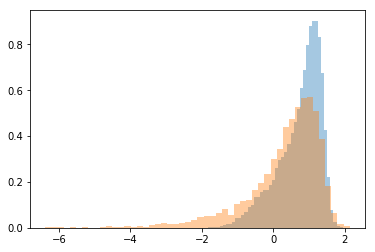

steps: 260 	 loss: 2.71943043271
steps: 270 	 loss: 3.41670557554
new best: 2.712926358320147
state: [0.3389852438032455, 0.32246106045507344, 0.3226598732935762, 0.32797707638741647, 0.35838469292914754, 0.3206165892367749, 0.3144264500959536, 0.32927724737351455, 0.34387736118427015, 0.3172474712391597, 0.09771514770537966, 0.28592929693025054]


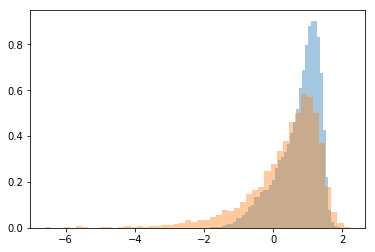

steps: 280 	 loss: 2.8998133132
steps: 290 	 loss: 3.38635673196
steps: 300 	 loss: 3.12204241755
steps: 310 	 loss: 3.05389616754
steps: 320 	 loss: 3.34517608011
steps: 330 	 loss: 4.18322587425
steps: 340 	 loss: 3.33996916335
steps: 350 	 loss: 3.18250635376
steps: 360 	 loss: 3.88779891189
steps: 370 	 loss: 2.98715079354
steps: 380 	 loss: 3.24789716224
steps: 390 	 loss: 3.50118900239
steps: 400 	 loss: 3.48621747007
steps: 410 	 loss: 3.2660520349
steps: 420 	 loss: 3.48422539369
steps: 430 	 loss: 3.47149079947
steps: 440 	 loss: 3.44696145832
steps: 450 	 loss: 3.48161539787
steps: 460 	 loss: 3.66344542082
steps: 470 	 loss: 3.31913609487
steps: 480 	 loss: 3.23033152321
steps: 490 	 loss: 3.50161172241
steps: 500 	 loss: 3.41092327738
steps: 510 	 loss: 3.34073115384
steps: 520 	 loss: 3.00502988332
steps: 530 	 loss: 3.13325128712
steps: 540 	 loss: 3.11393063466
steps: 550 	 loss: 3.56221067008
steps: 560 	 loss: 3.20602725721
steps: 570 	 loss: 3.0039182473
new best: 2.6

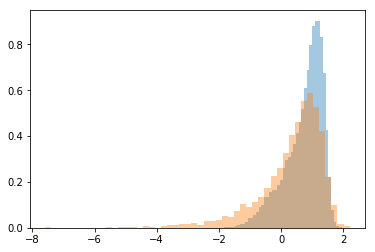

steps: 580 	 loss: 2.67591560157
steps: 590 	 loss: 3.05755147454
steps: 600 	 loss: 2.83993087642
new best: 2.4777416579311997
state: [0.3467250144448724, 0.32549142999946895, 0.3224627687663842, 0.31460104002081996, 0.3423484367768743, 0.3086893238137966, 0.32575616266918367, 0.33838390928574813, 0.34953986785578106, 0.30535442312721417, 0.10057108022549784, 0.2610477499918499]


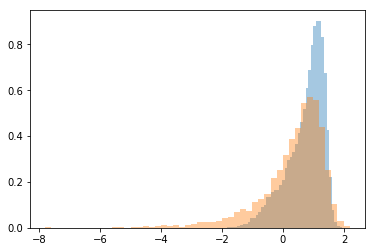

steps: 610 	 loss: 3.13786787433
steps: 620 	 loss: 3.06786367981
new best: 2.4586744495607373
state: [0.35139757988574916, 0.3225897376531013, 0.3231256166645264, 0.31999084857183613, 0.3401455260778522, 0.31050764101354256, 0.32704633418487006, 0.329773903663409, 0.3477634677238127, 0.30698489544615476, 0.1004573217351619, 0.25438127438266717]


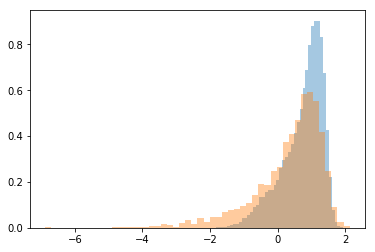

steps: 630 	 loss: 2.64820259689
steps: 640 	 loss: 3.28117613689
steps: 650 	 loss: 3.15600290411
steps: 660 	 loss: 3.20413157699
steps: 670 	 loss: 3.75319722276
steps: 680 	 loss: 3.42813833625
steps: 690 	 loss: 3.28790333765
steps: 700 	 loss: 3.06757023849
steps: 710 	 loss: 3.72152596293
steps: 720 	 loss: 3.5270824355
steps: 730 	 loss: 3.00534304937
steps: 740 	 loss: 3.88828017141
steps: 750 	 loss: 3.42987638574
steps: 760 	 loss: 3.31636822727
steps: 770 	 loss: 3.1351724403
steps: 780 	 loss: 3.14052006136
steps: 790 	 loss: 3.26627525339
steps: 800 	 loss: 3.12731399913
steps: 810 	 loss: 3.06727692131
steps: 820 	 loss: 3.09689097554
steps: 830 	 loss: 3.21748475089
steps: 840 	 loss: 3.19381017174
steps: 850 	 loss: 2.91368471465
steps: 860 	 loss: 3.25102017725
steps: 870 	 loss: 3.15897744744
steps: 880 	 loss: 2.88361310412
steps: 890 	 loss: 3.63570372775
steps: 900 	 loss: 3.57048103007
steps: 910 	 loss: 3.27446425596
steps: 920 	 loss: 2.8991448212
steps: 930 	 

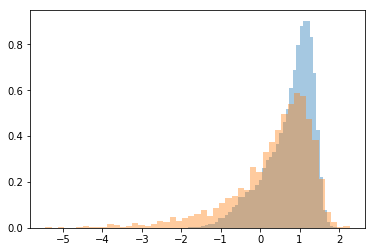

steps: 1340 	 loss: 3.33059576282
steps: 1350 	 loss: 3.40207232788
steps: 1360 	 loss: 3.17173688222
steps: 1370 	 loss: 3.12625255012
steps: 1380 	 loss: 3.1725908322
steps: 1390 	 loss: 3.11160114383
steps: 1400 	 loss: 2.83725681917
steps: 1410 	 loss: 3.56242271649
steps: 1420 	 loss: 2.93968292454
steps: 1430 	 loss: 3.38918498165
steps: 1440 	 loss: 3.32133929968
steps: 1450 	 loss: 2.98067891886
steps: 1460 	 loss: 3.4712673209
steps: 1470 	 loss: 3.55438337531
steps: 1480 	 loss: 3.15457229953
steps: 1490 	 loss: 3.20598230184
steps: 1500 	 loss: 3.1309075318
steps: 1510 	 loss: 3.12814978792
steps: 1520 	 loss: 2.68269782259
steps: 1530 	 loss: 3.10830758598
steps: 1540 	 loss: 3.05010060912
steps: 1550 	 loss: 2.72685704957
steps: 1560 	 loss: 3.08661043554
steps: 1570 	 loss: 3.06311594875
steps: 1580 	 loss: 3.08613742868
steps: 1590 	 loss: 3.02792753897
steps: 1600 	 loss: 2.96093872733
steps: 1610 	 loss: 3.04767285415
steps: 1620 	 loss: 3.25978643863
steps: 1630 	 los

steps: 3760 	 loss: 2.38240199686
steps: 3770 	 loss: 3.29429310075
steps: 3780 	 loss: 3.24451823382
steps: 3790 	 loss: 3.00210800876
steps: 3800 	 loss: 3.25506177354
steps: 3810 	 loss: 2.92375055113
steps: 3820 	 loss: 2.78748957743
steps: 3830 	 loss: 3.109509825
steps: 3840 	 loss: 2.66130257554
steps: 3850 	 loss: 2.82220533137
steps: 3860 	 loss: 3.1018005001
steps: 3870 	 loss: 2.84662564955
steps: 3880 	 loss: 3.13323140238
steps: 3890 	 loss: 3.05601067258
steps: 3900 	 loss: 2.62920441655
steps: 3910 	 loss: 2.87439107736
steps: 3920 	 loss: 2.93405613813
steps: 3930 	 loss: 3.24738609456
steps: 3940 	 loss: 2.72426463779
steps: 3950 	 loss: 2.9965401494
steps: 3960 	 loss: 3.08731718088
steps: 3970 	 loss: 2.45507066295
steps: 3980 	 loss: 2.92386206234
steps: 3990 	 loss: 2.97157946923
steps: 4000 	 loss: 2.93890941634
steps: 4010 	 loss: 3.09103352089
steps: 4020 	 loss: 3.24332647891
steps: 4030 	 loss: 3.11972939807
steps: 4040 	 loss: 3.18823445476
steps: 4050 	 loss

KeyboardInterrupt: 

In [6]:
gradient_descent(initial_vars(10), num_iter=10000, gradwidth=.01, lr=.0001, real_eigs = CY_eigs[10]) 

In [ ]:
gradient_descent(initial_vars(10), num_iter=2000, gradwidth=.01, lr=.0001, real_eigs = CY_eigs[50]) 